In [1]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from ..models import CifarAEC
from ..utils import *

log_to_stdout()

In [2]:
batch_size = 1
device = torch.device("cpu")
loss_fn = nn.MSELoss()

In [3]:
training_data = datasets.CIFAR10(
    root="../data",
    download=True,
    train=True,
    transform=ToTensor(),
)
training_classes = torch.tensor(training_data.targets)
training_ind = (training_classes == 0) | (training_classes == 1)
training_data = Subset(training_data, torch.nonzero(training_ind))

test_data = datasets.CIFAR10(
    root="../data",
    download=True,
    train=False,
    transform=ToTensor(),
)
test_classes = torch.tensor(test_data.targets)
test_ind = (test_classes == 0) | (test_classes == 1)
test_data = Subset(test_data, torch.nonzero(test_ind))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_dataloader = DataLoader(training_data, batch_size, True)
test_dataloader = DataLoader(test_data, batch_size, True)

In [5]:
model = CifarAEC().to(device)
model.load_state_dict(
    torch.load("../finals/CifarAEC.pth", map_location=device), strict=True
)
model.eval()

CifarAEC(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=100, threshold=20)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Softplus(beta=100, threshold=20)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Softplus(beta=100, threshold=20)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Softplus(beta=100, threshold=20)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=128, bias=True)
  )
  (decoder): Seq

In [6]:
for X, labels in test_dataloader:
    break
X = X.to(device)

In [7]:
with torch.no_grad():
    Y = model.encoder(X)

In [8]:
Y

tensor([[-6.9992e+01, -2.6459e+01, -1.8239e+01, -1.3026e+01,  3.3695e+01,
          9.5769e+01, -2.2232e+00, -4.7240e+00, -3.2101e+01, -5.3804e+00,
          3.0001e+01,  3.7606e+01,  4.8346e+01,  1.6217e+00,  4.9802e+01,
          7.6034e+00,  4.7808e+01,  2.0006e+01,  6.2461e+01,  9.5233e+00,
         -2.1532e+01, -5.7072e+01,  7.1225e-01, -2.5372e+01, -1.0247e+00,
          1.8184e+01,  9.3432e+01,  9.0438e+01, -7.1019e+01, -5.2700e+01,
         -2.0944e+01,  2.8505e+01, -1.0286e+01, -3.4182e+01, -5.8561e+00,
         -4.0386e+01, -2.3331e+01,  4.1665e+01,  1.0779e+01,  3.7401e+01,
          4.1718e+01, -3.4904e+01, -1.3656e+00,  1.2876e+01,  3.2409e+01,
         -2.0198e+01, -9.9649e+00,  1.7582e+01, -2.6751e+01,  1.3241e+01,
         -2.4114e+01,  3.8190e+01,  3.8401e+01,  2.5562e+01, -1.6787e+01,
         -3.3852e+00, -3.5298e+01,  2.0428e+01, -7.6617e+00, -5.5934e+00,
          1.8496e+01, -2.3369e+01,  1.7844e+01,  5.1351e+01,  4.9759e+00,
          5.2964e+01,  2.4198e+01, -5.

In [9]:
Y.requires_grad_(True)
Z = model.decoder(Y)
G = torch.empty(3072, 128)
for i in range(3072):
    model.zero_grad()
    if i > 0:
        Y.grad *= 0.0
    torch.flatten(Z)[i].backward(retain_graph=(i < 3071))
    G[i] = Y.grad
Z.detach_()

In [10]:
H = G.T.resize(128, 3, 32, 32)

/Users/lukas/miniconda3/envs/torch-env/lib/python3.10/site-packages/torch/_tensor.py:755: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [11]:
torch.all(Y.grad == H[:, 2, 31, 31])

tensor(True)

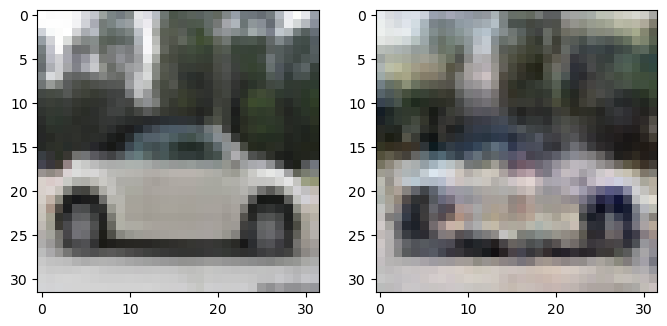

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(torch.permute(X.squeeze(), (1, 2, 0)))
axs[1].imshow(torch.permute(Z.squeeze(), (1, 2, 0)))
plt.show()

In [13]:
maxs = H.max(-1).values.max(-1).values.max(-1).values
mins = H.min(-1).values.min(-1).values.min(-1).values

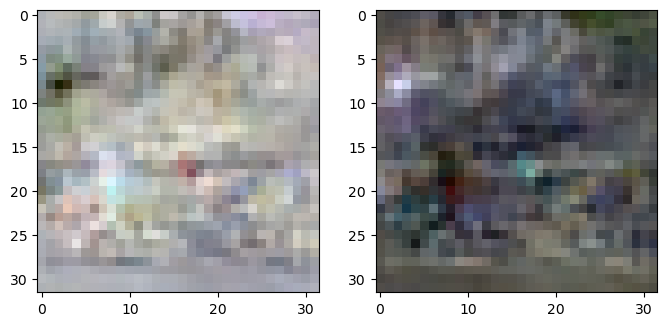

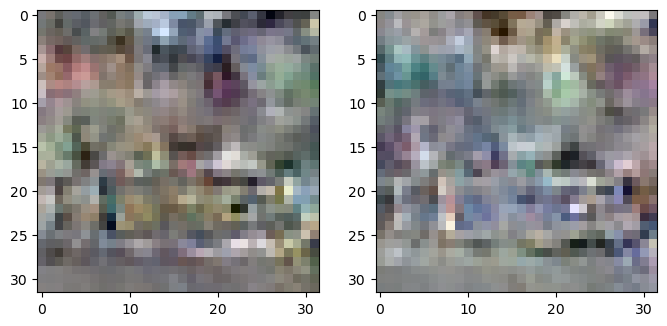

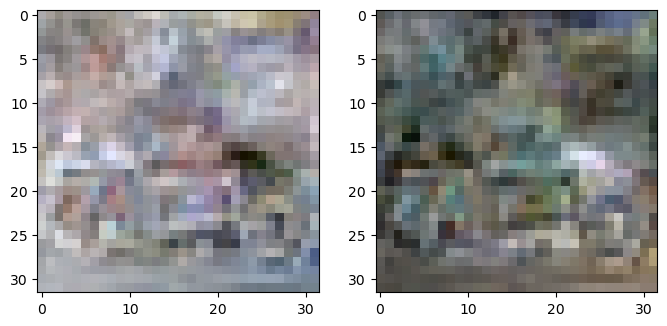

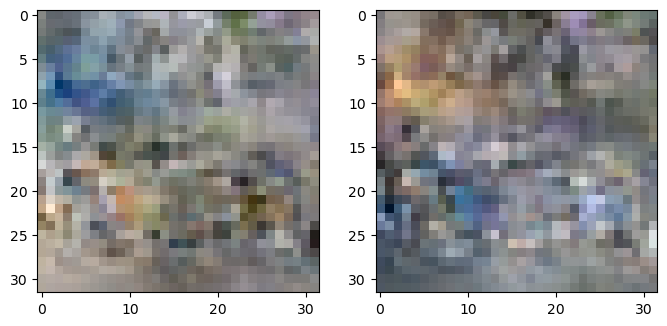

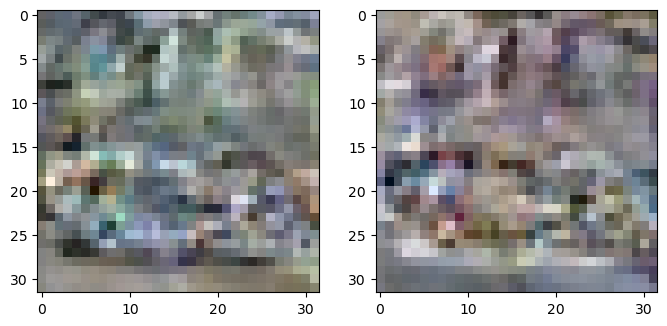

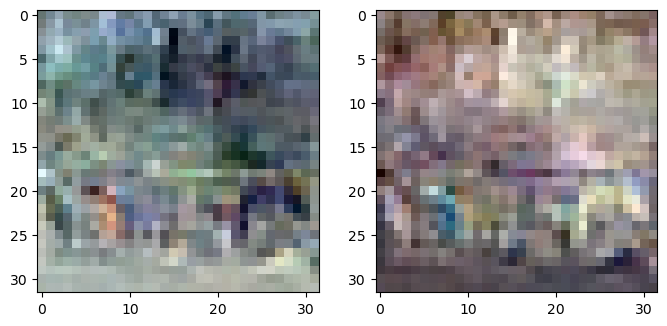

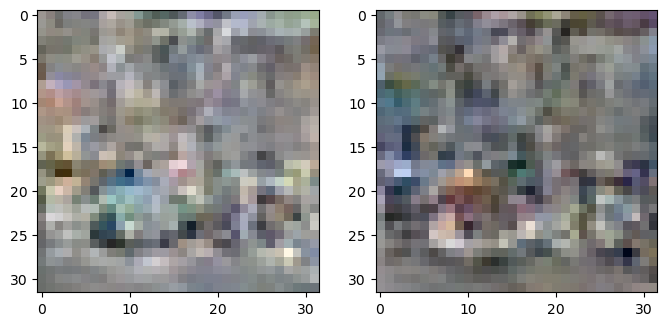

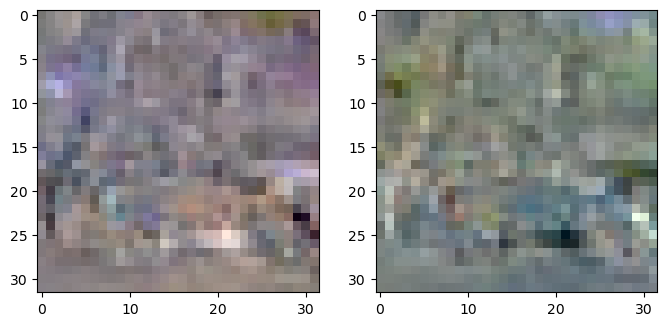

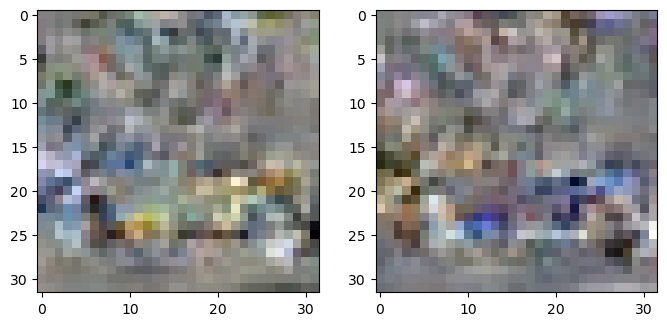

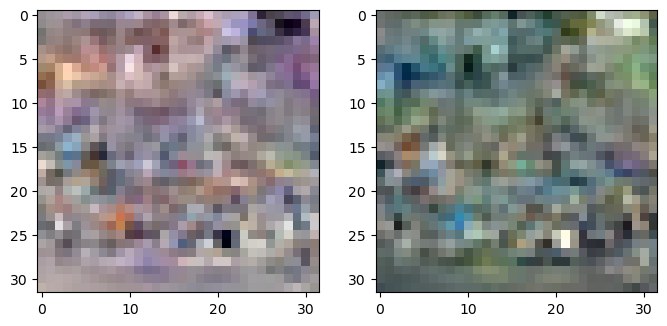

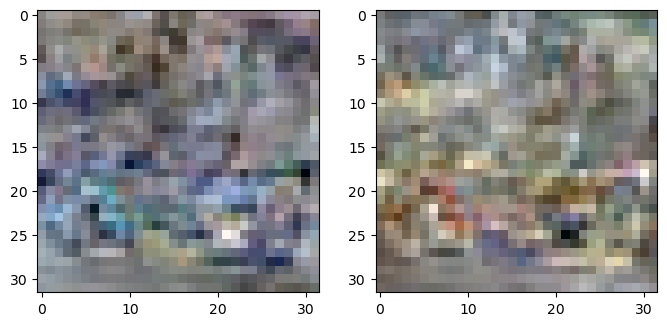

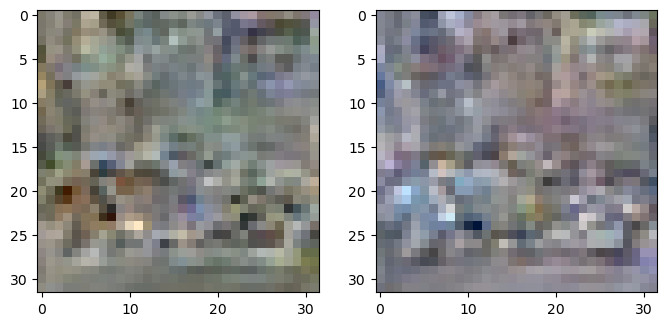

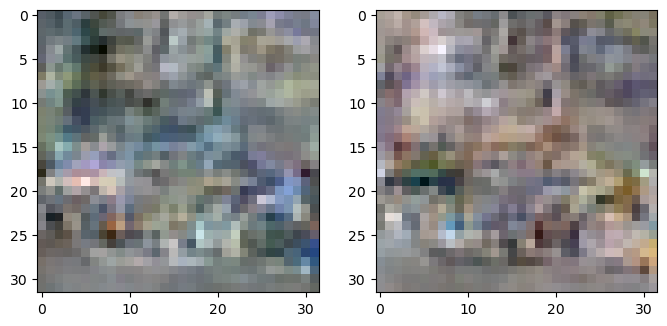

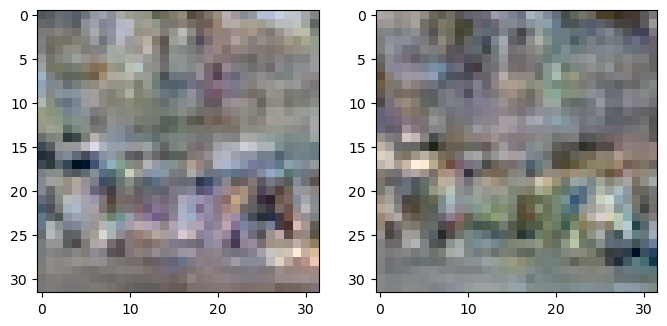

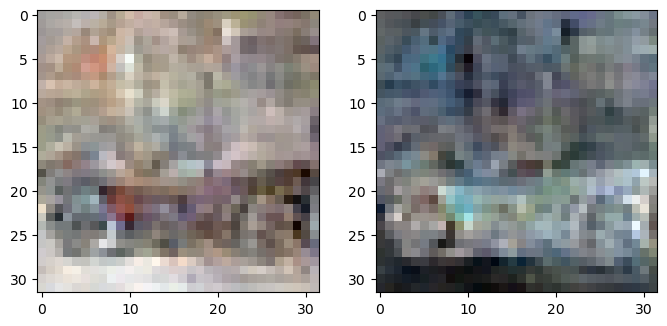

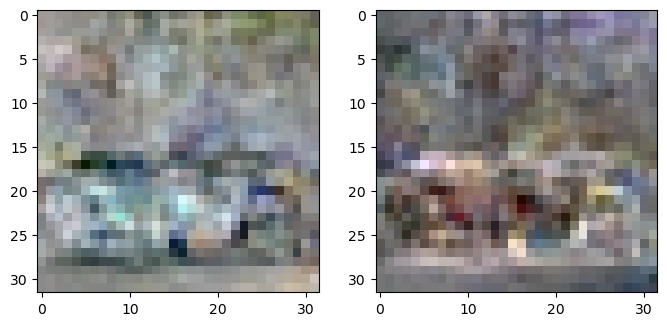

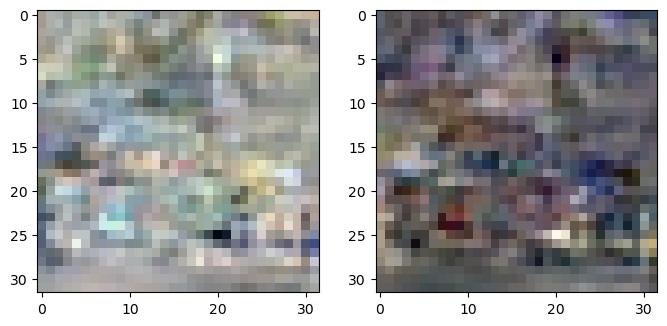

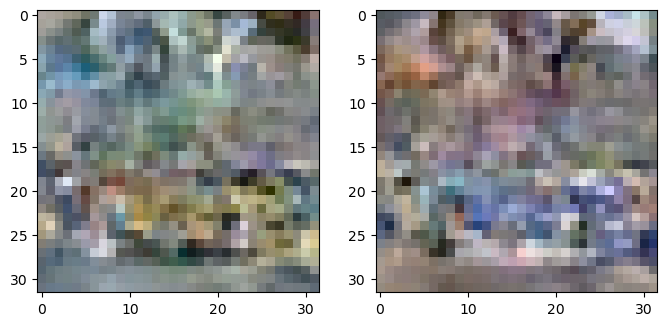

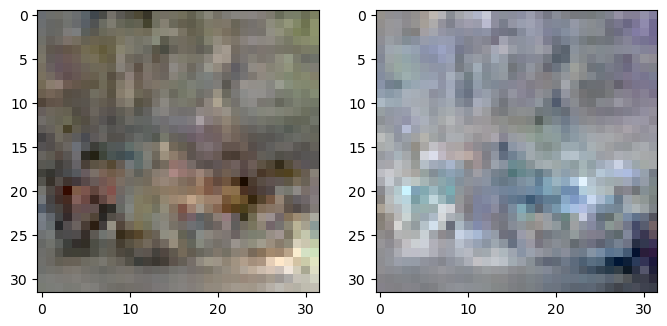

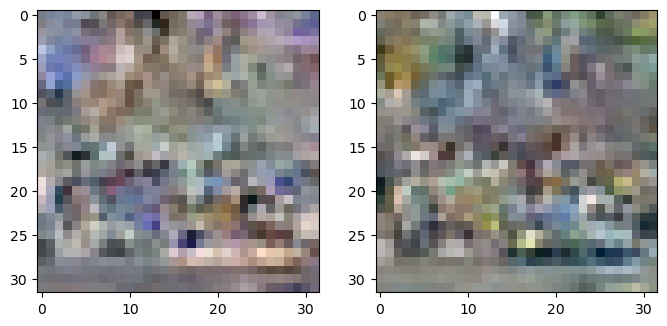

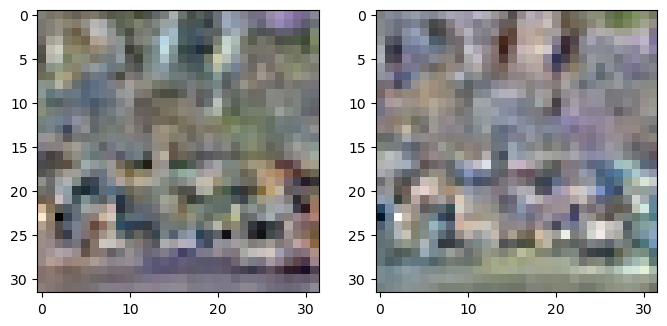

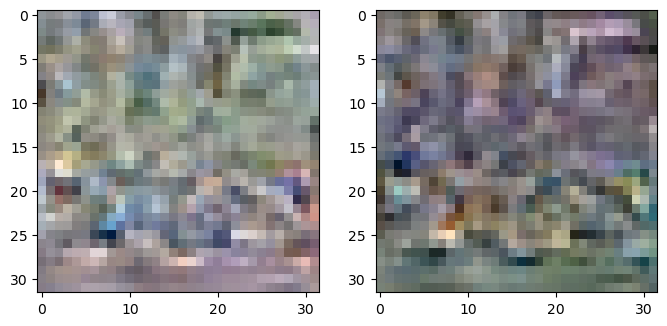

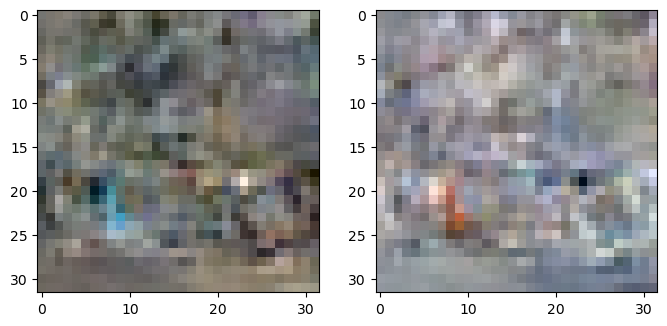

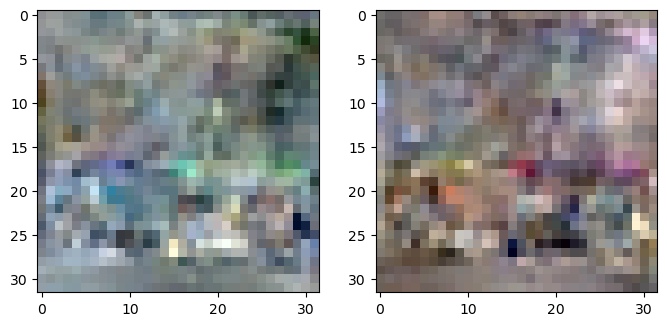

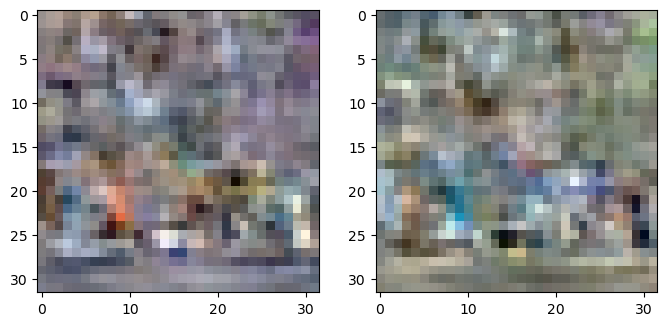

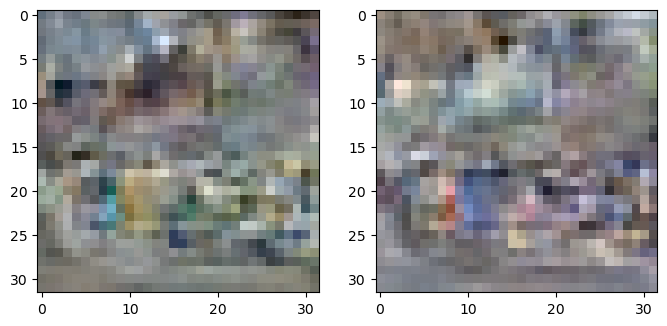

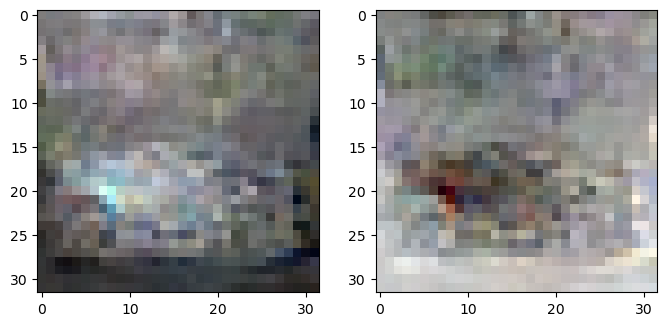

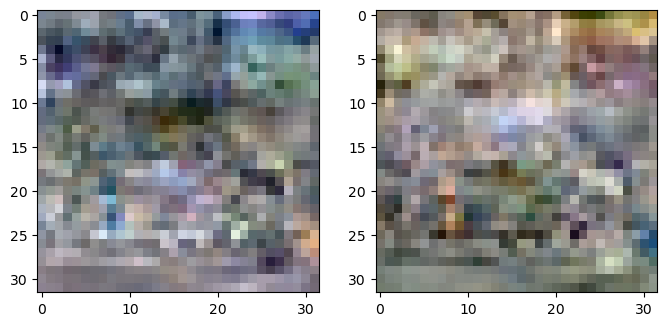

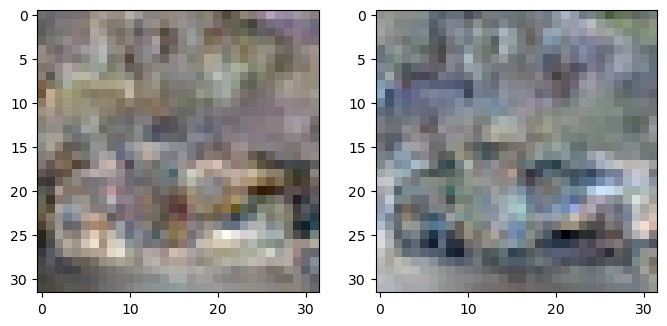

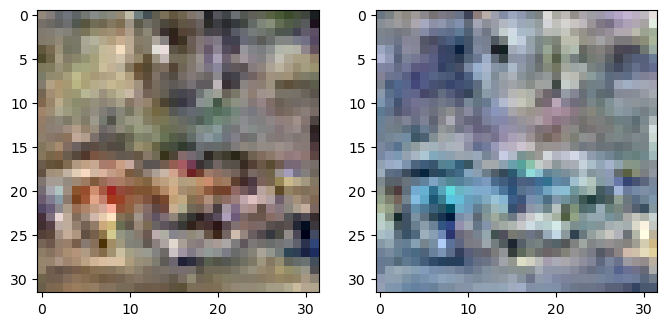

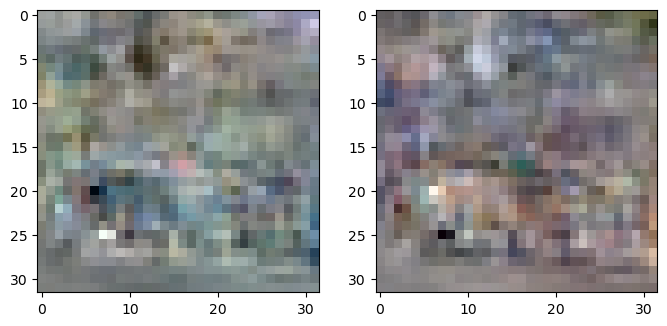

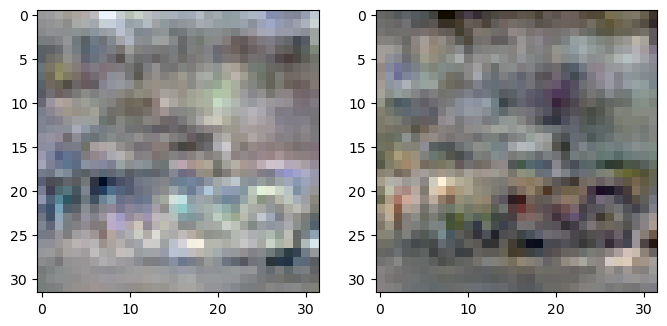

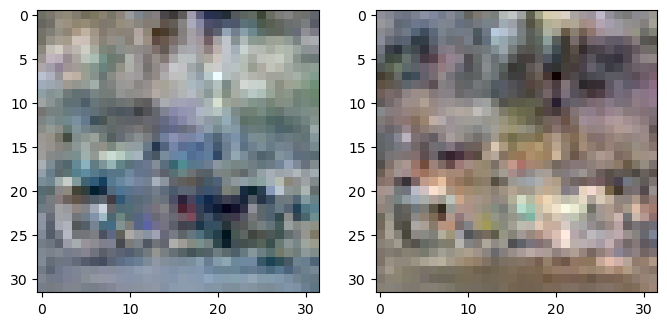

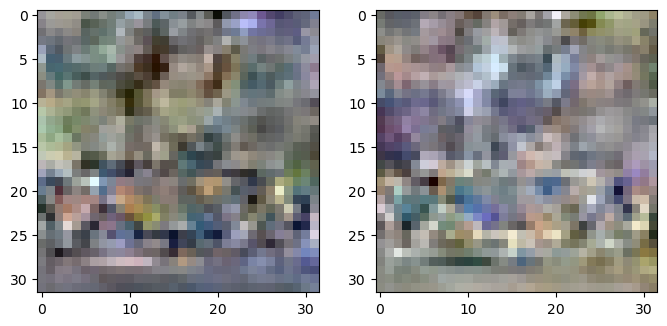

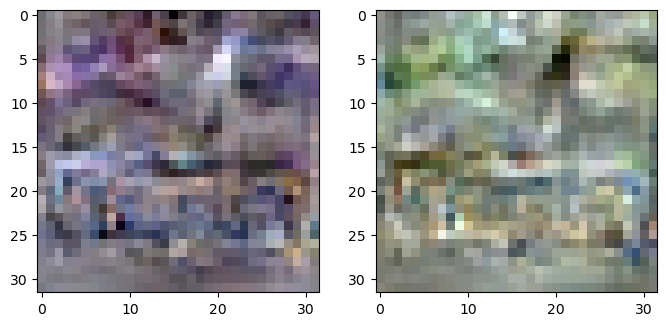

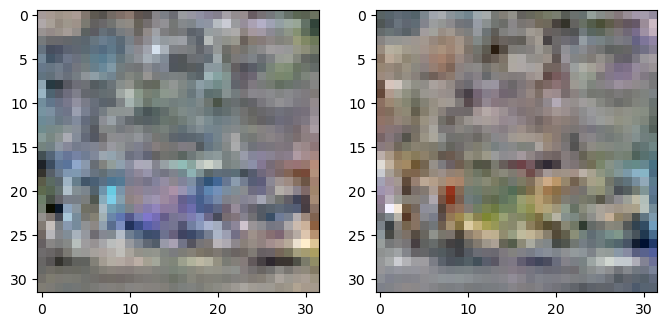

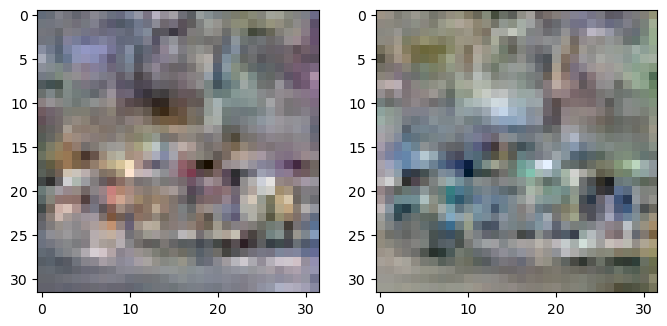

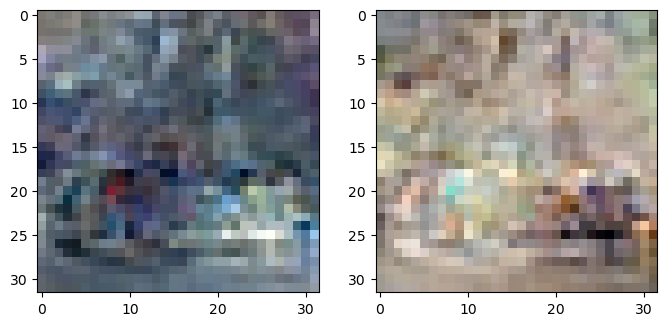

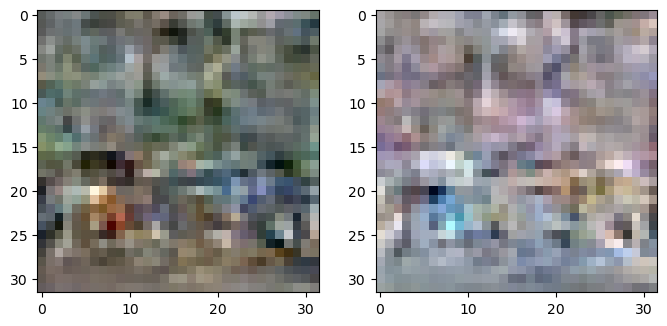

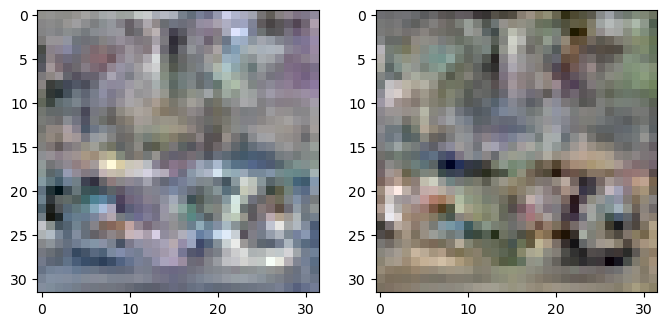

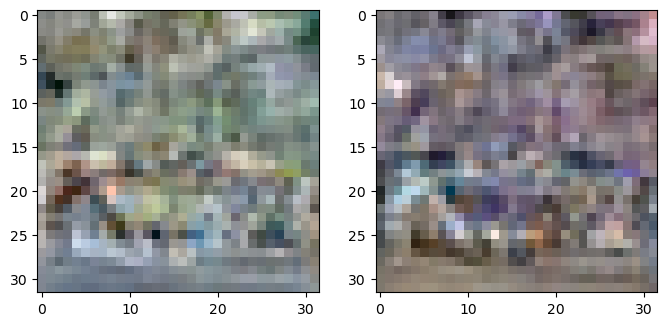

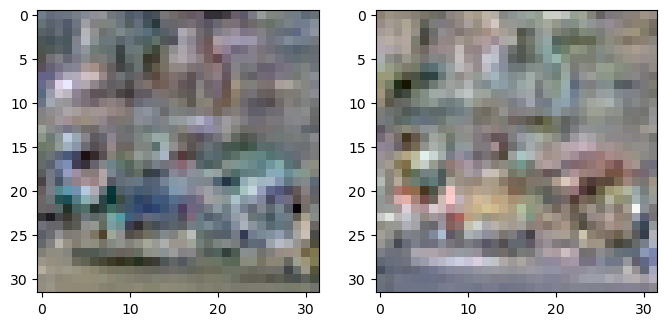

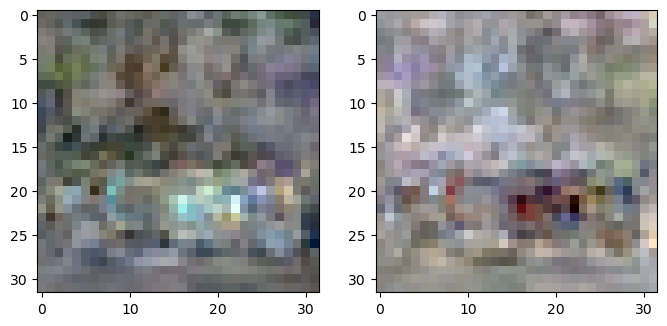

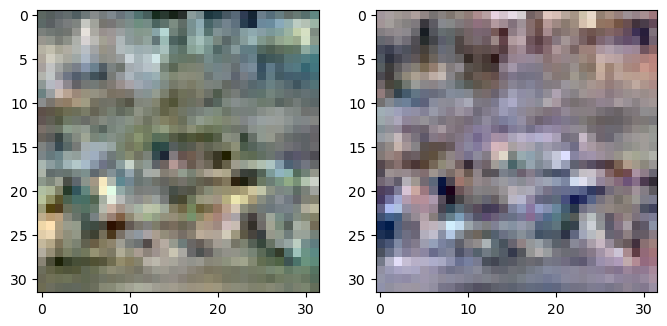

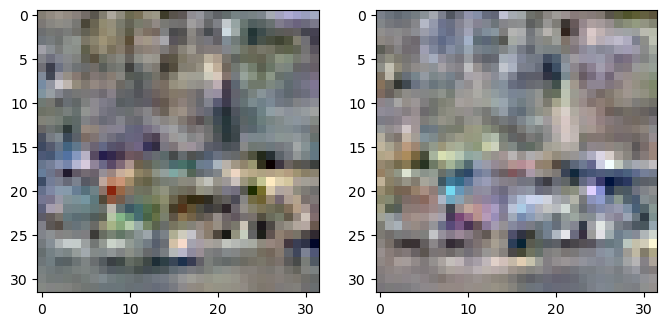

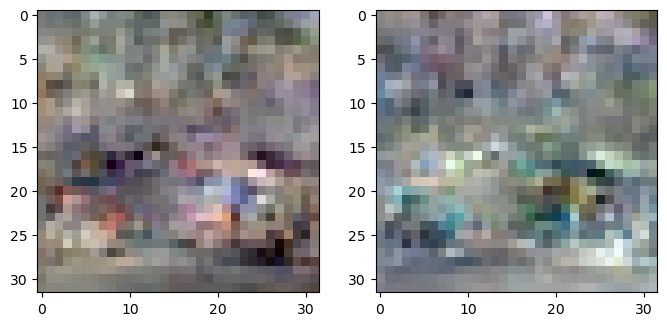

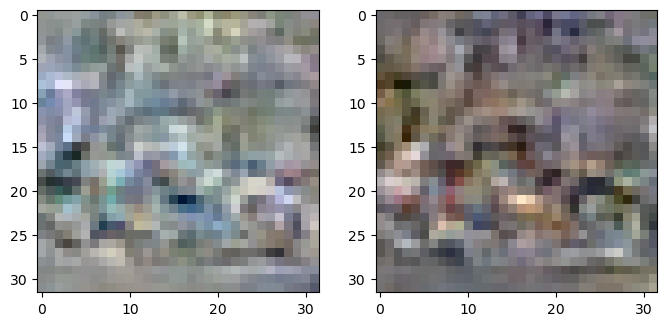

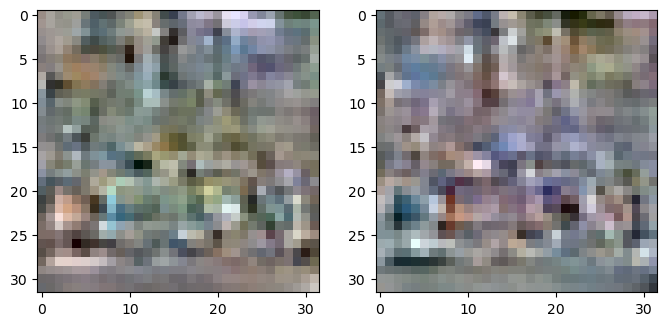

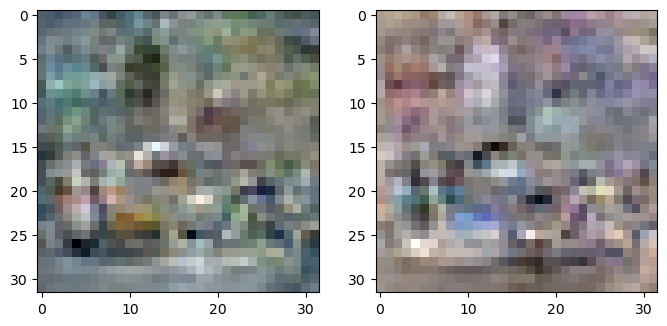

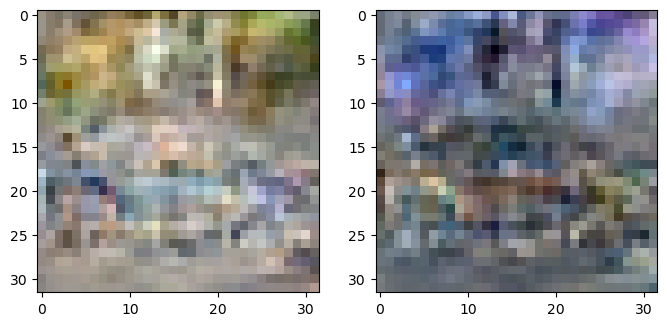

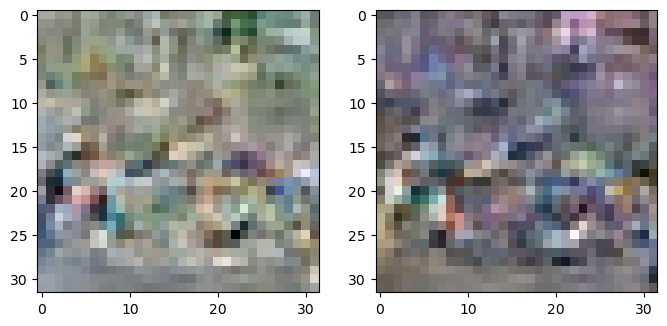

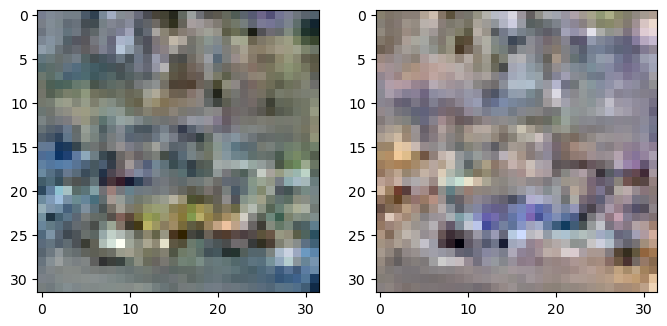

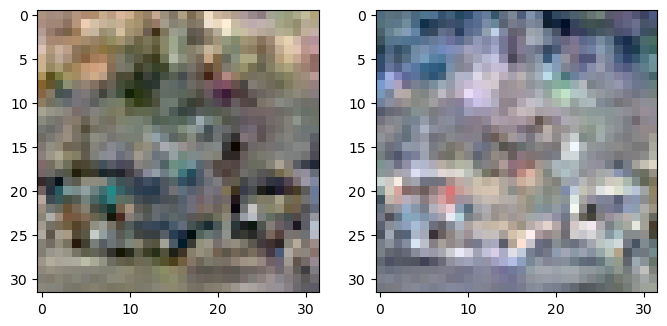

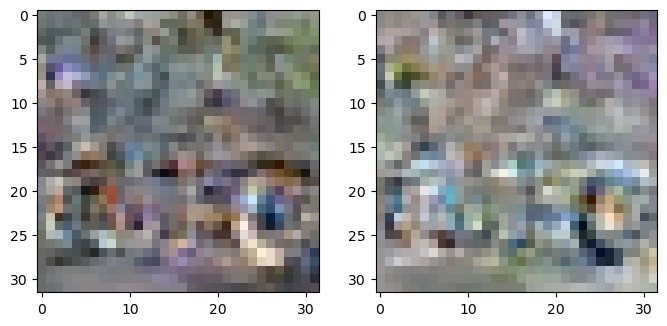

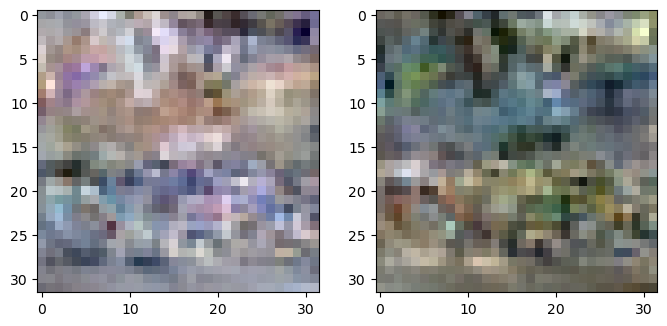

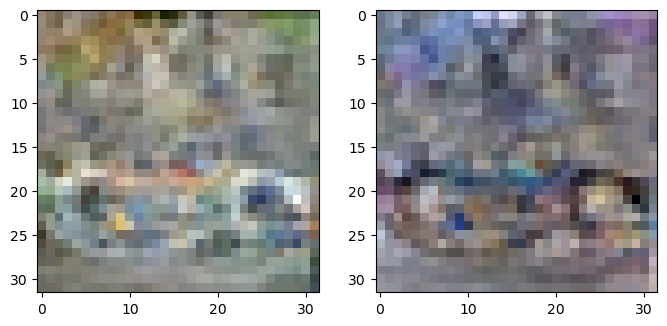

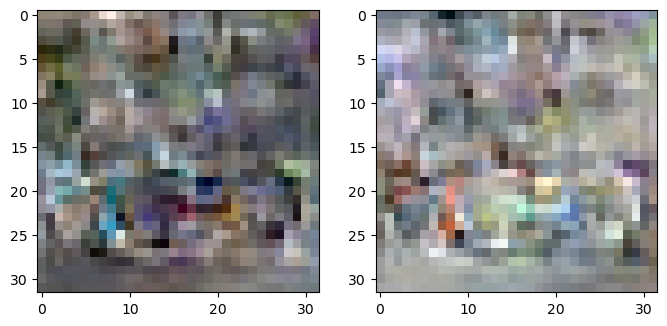

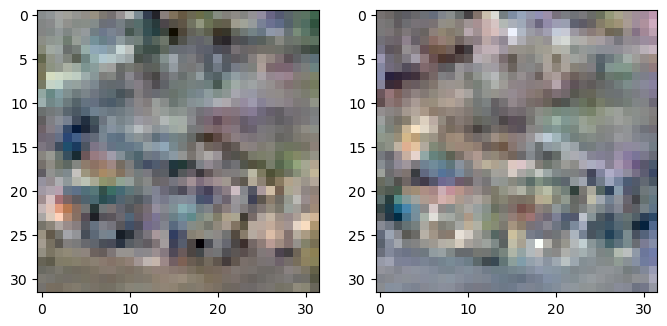

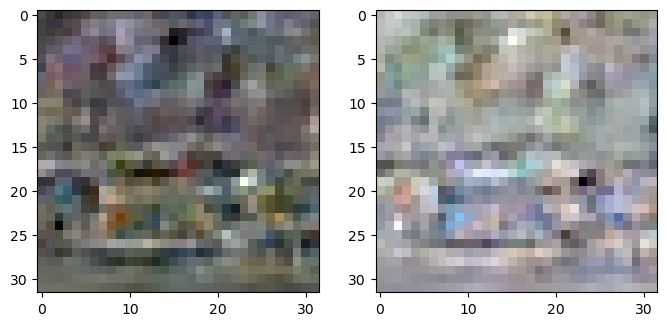

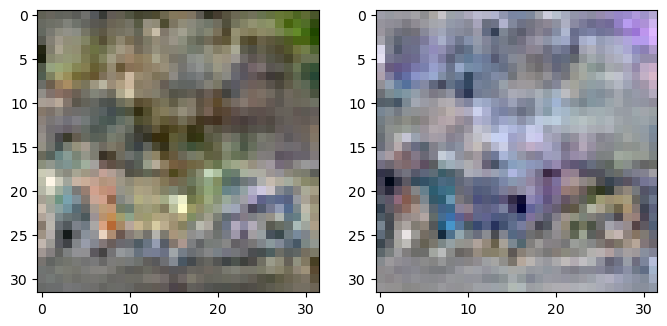

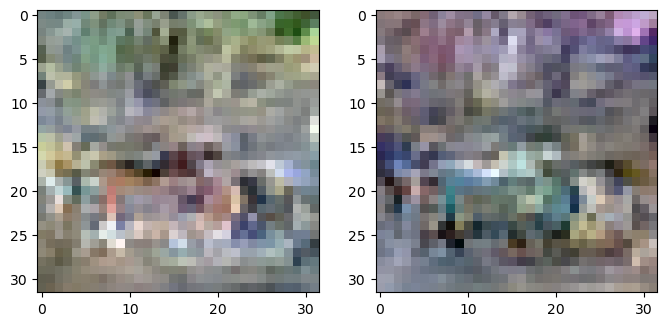

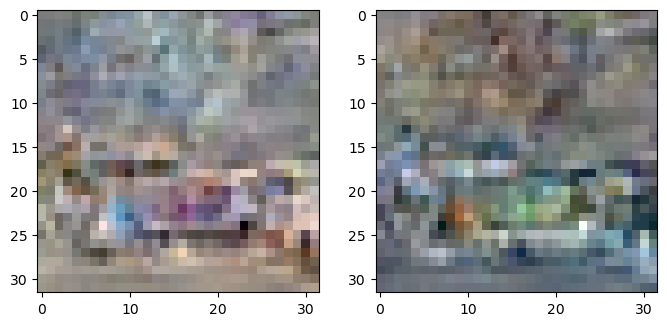

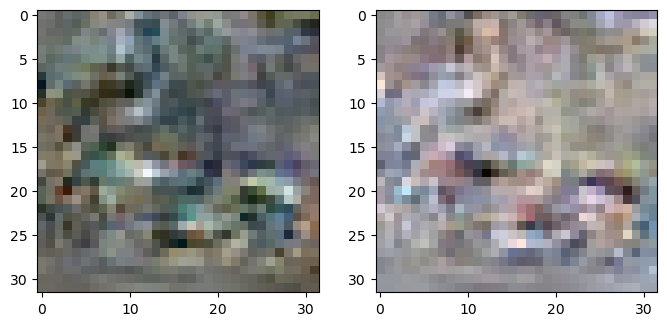

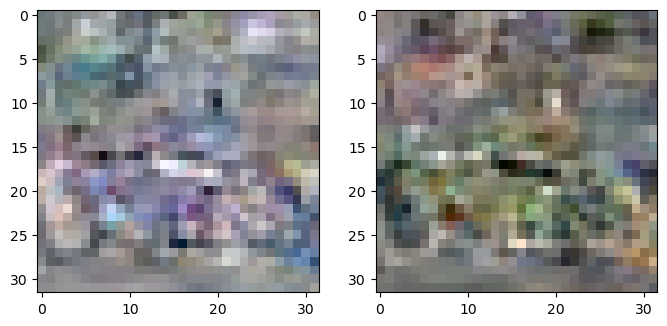

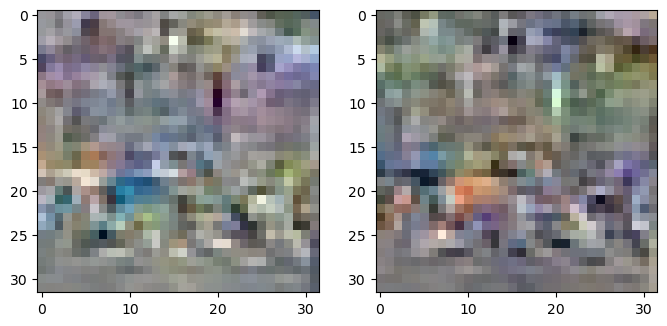

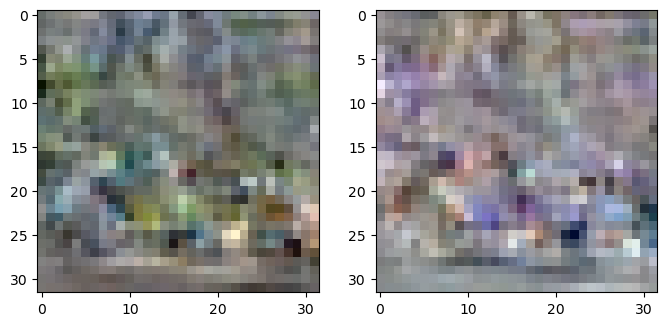

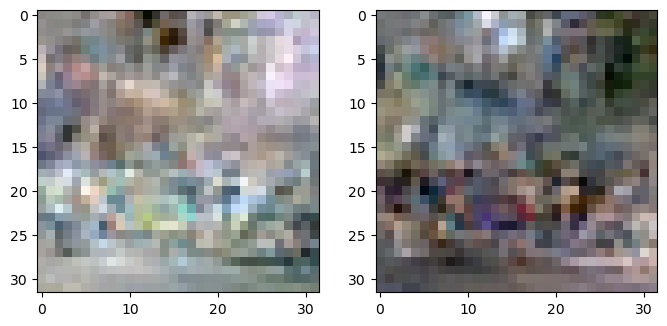

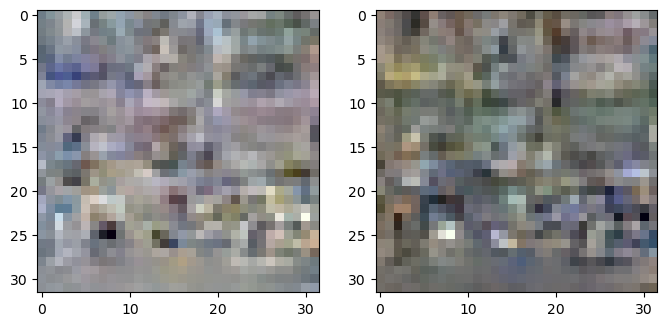

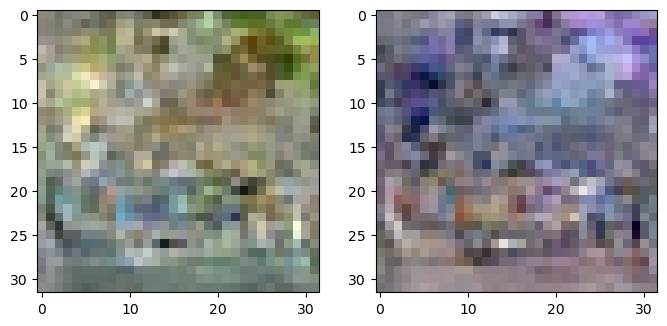

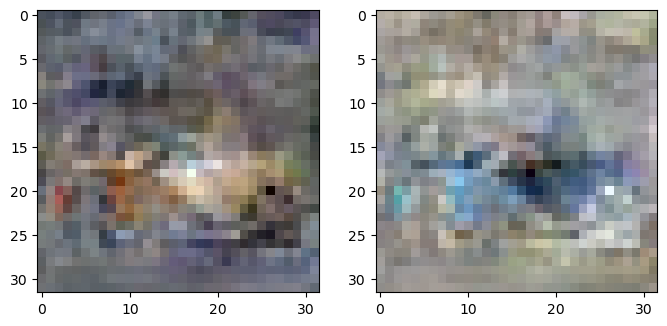

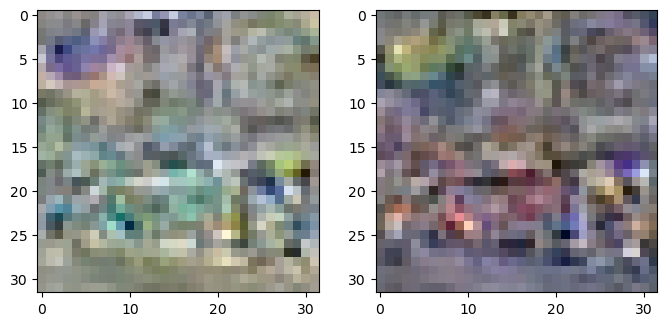

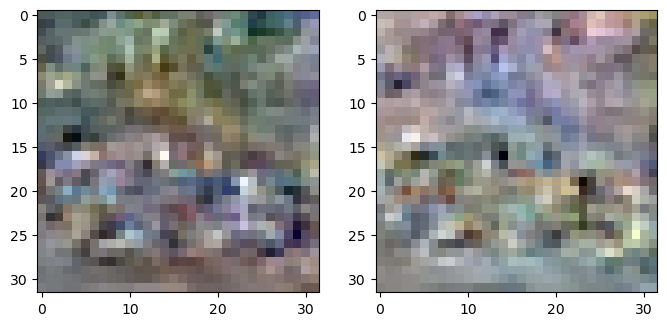

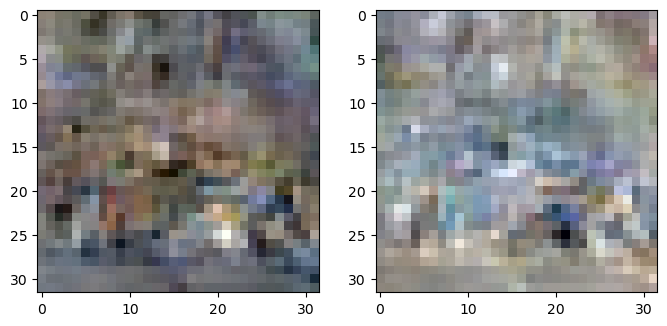

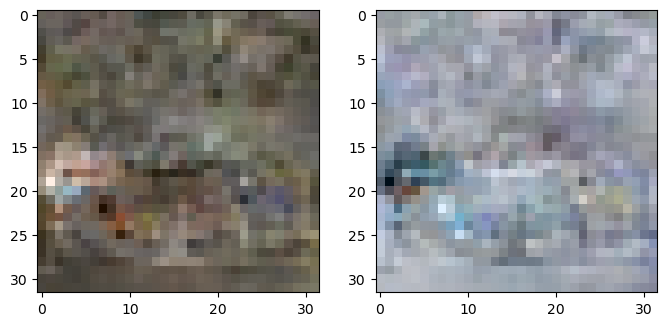

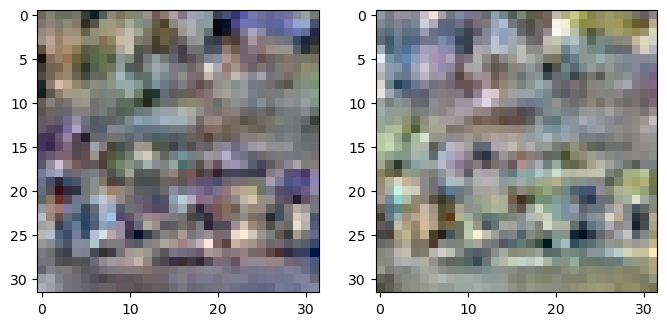

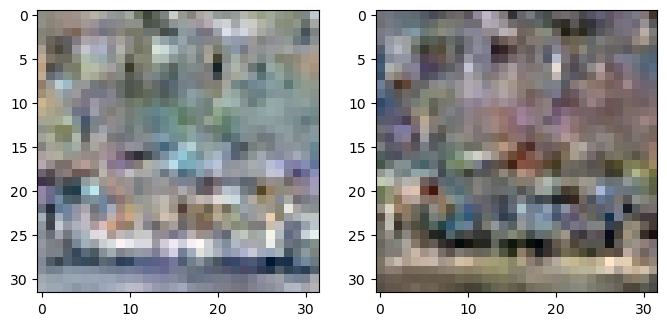

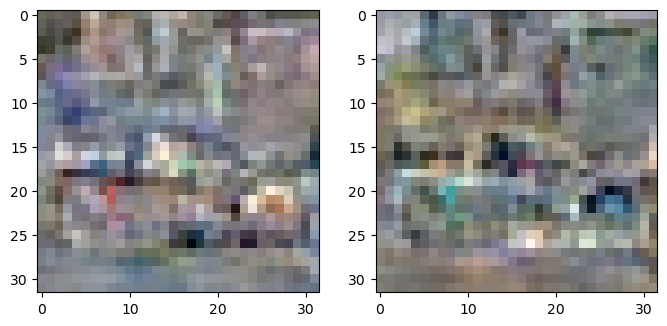

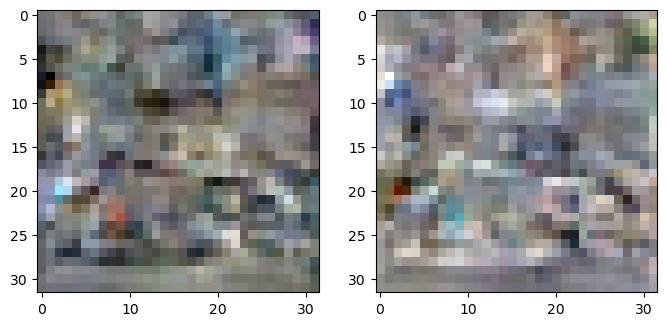

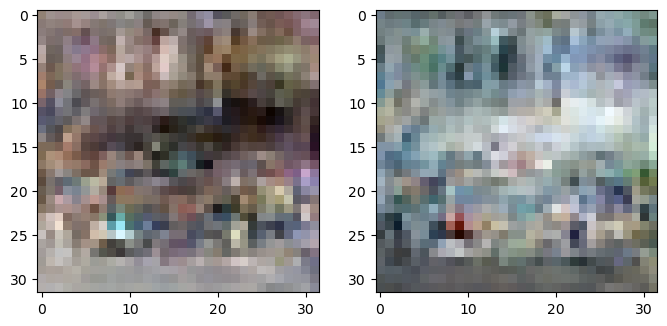

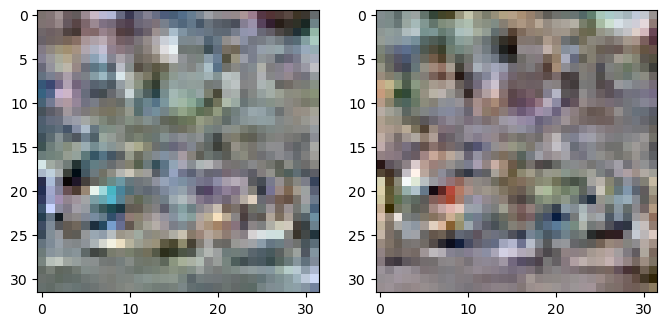

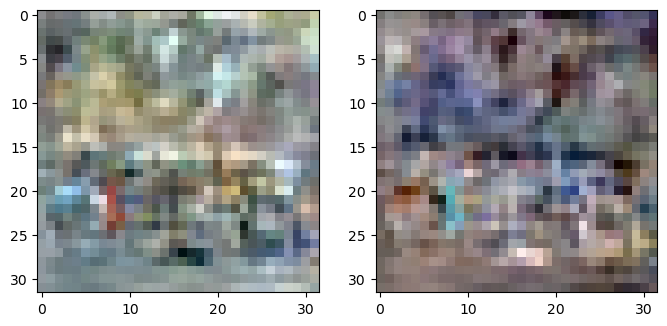

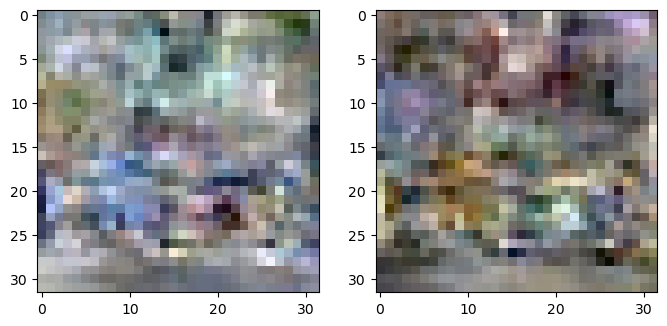

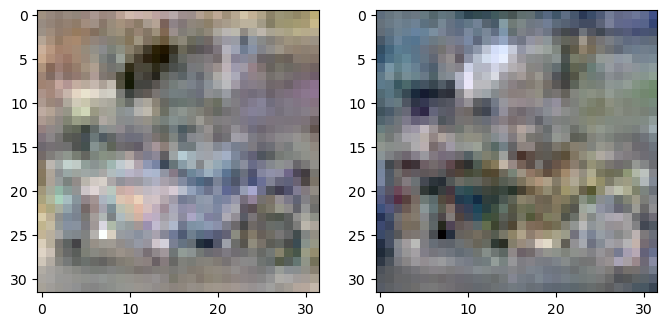

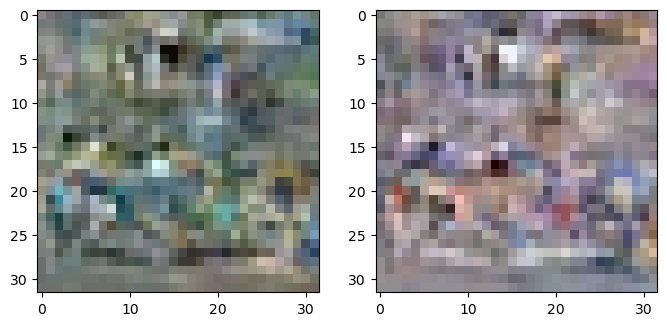

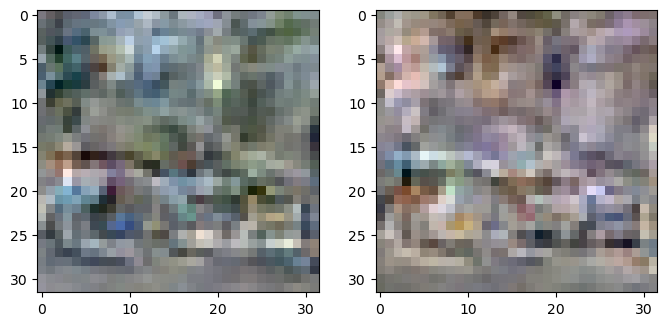

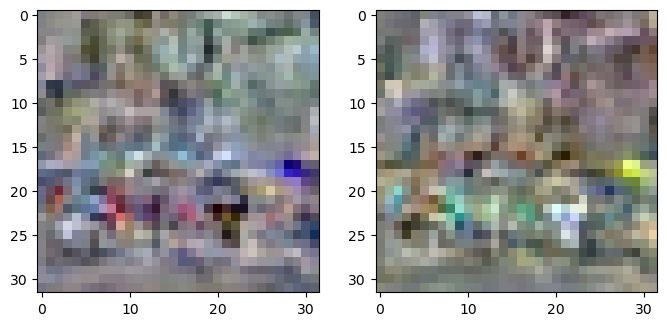

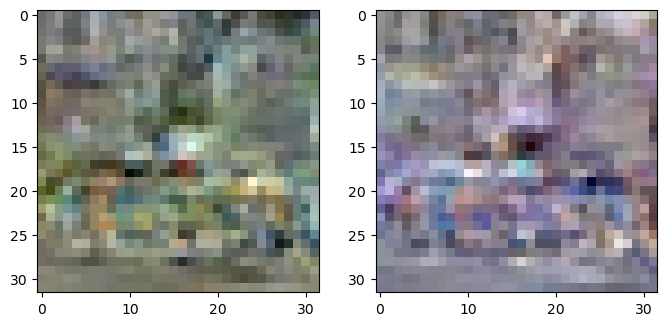

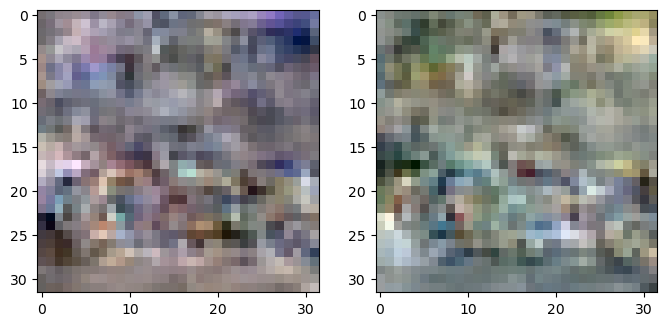

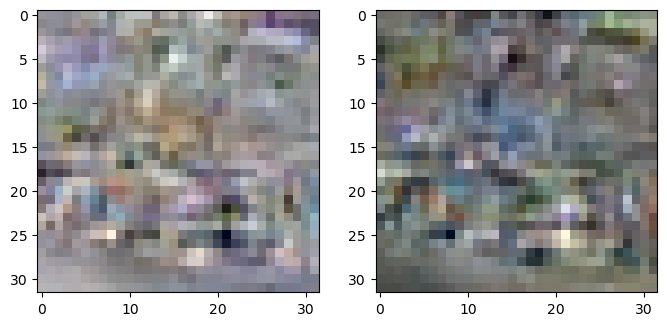

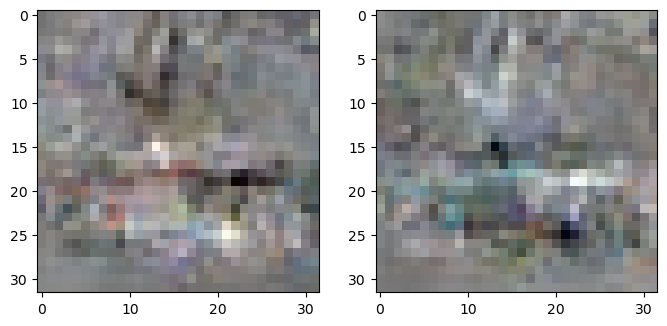

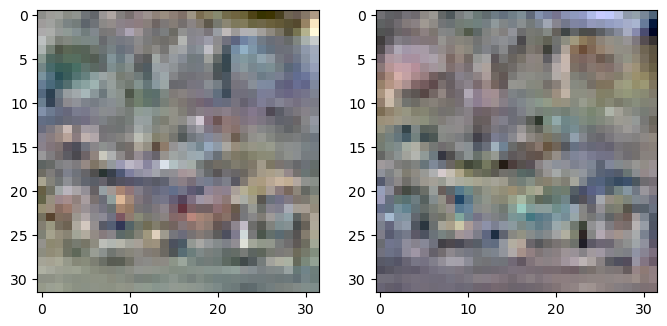

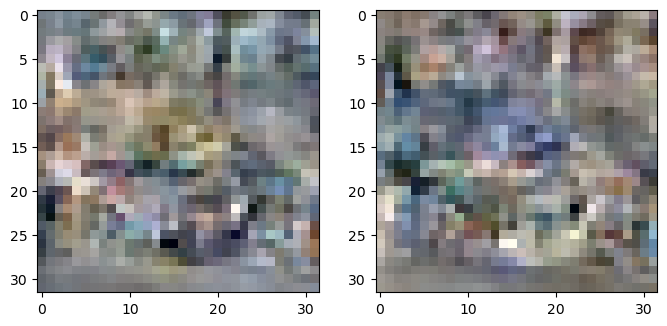

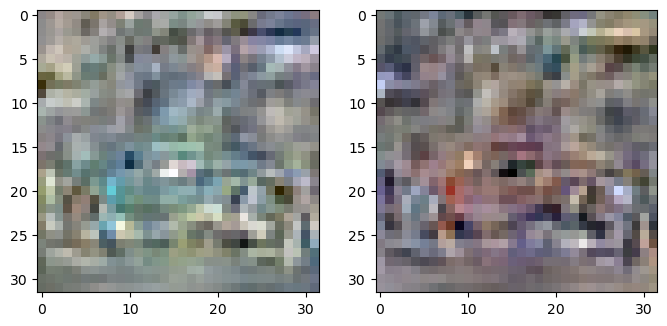

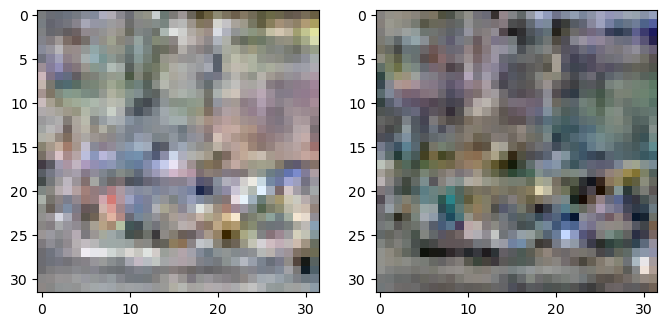

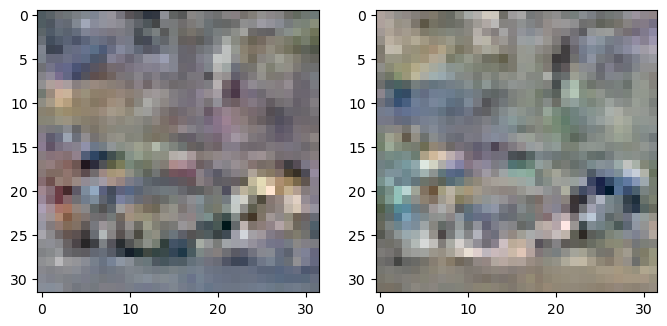

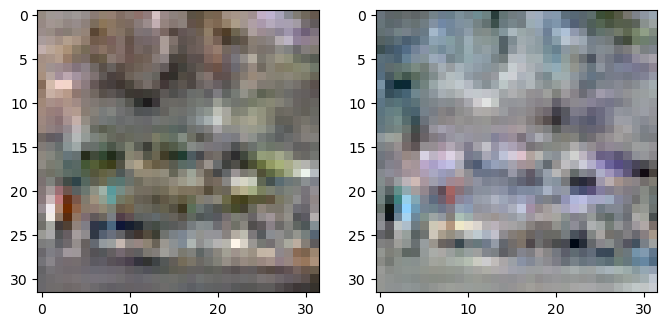

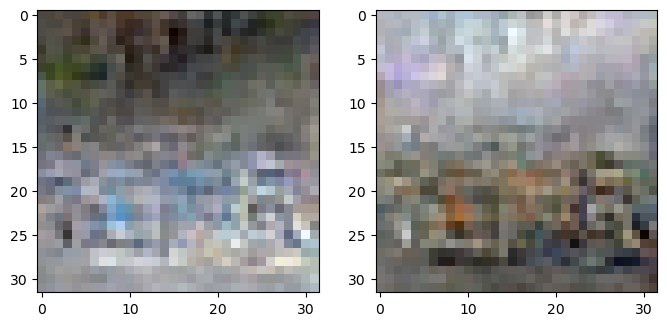

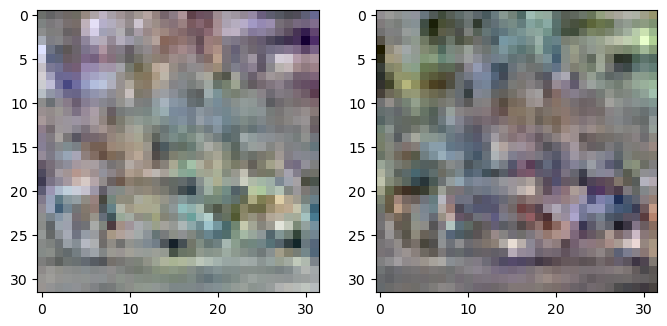

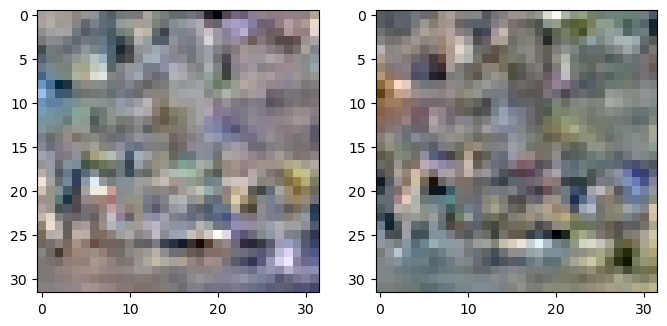

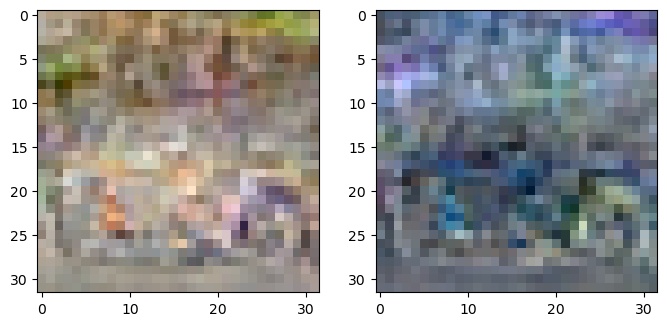

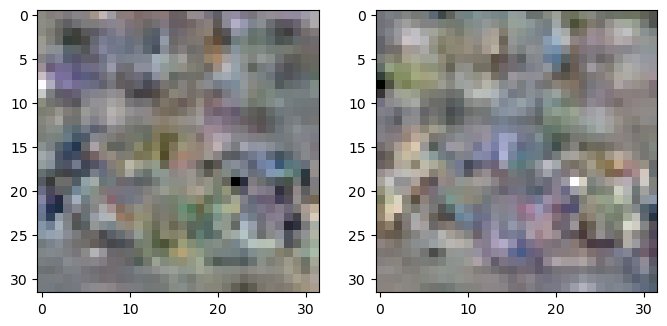

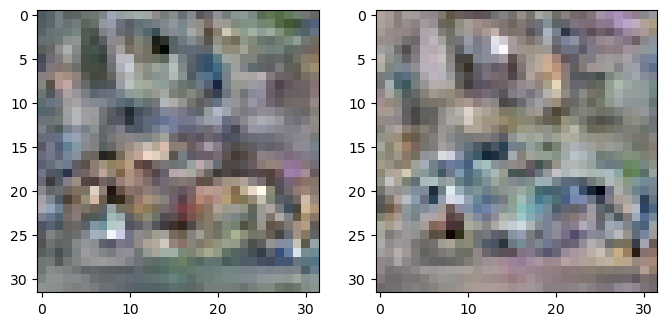

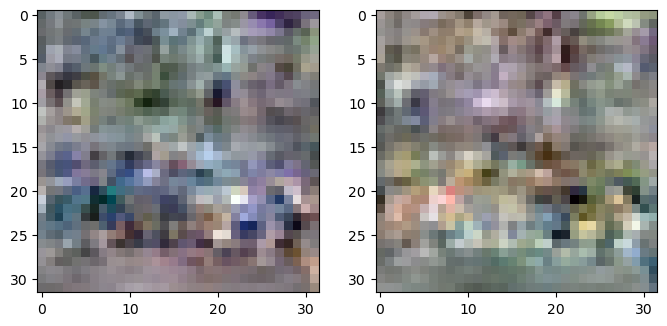

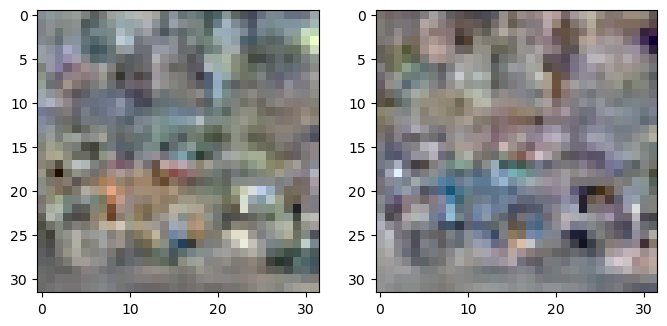

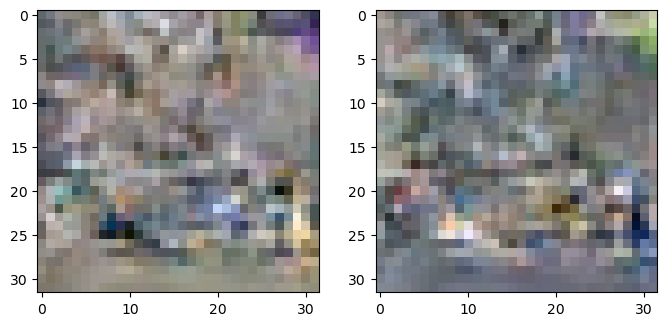

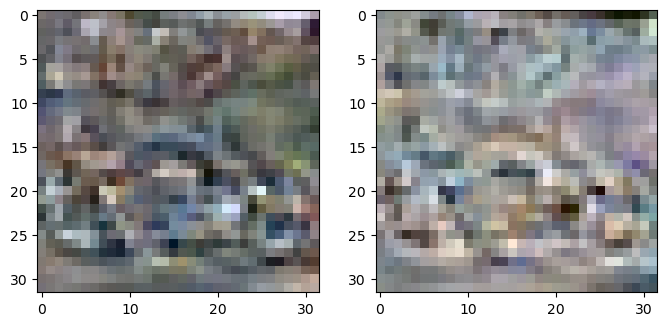

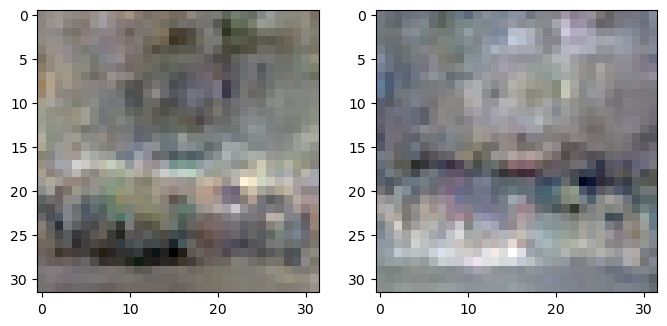

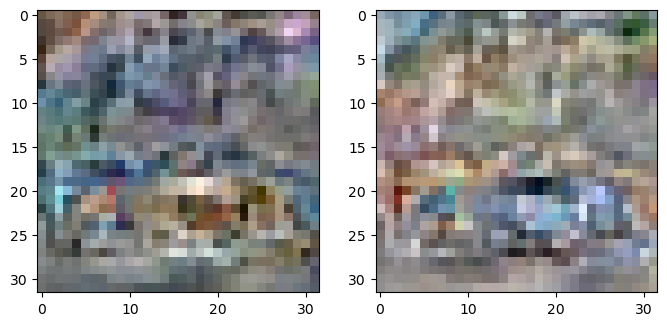

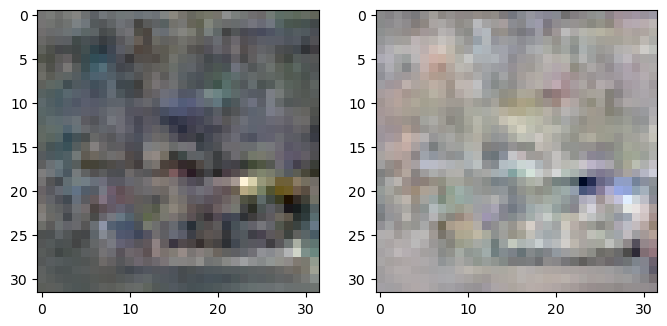

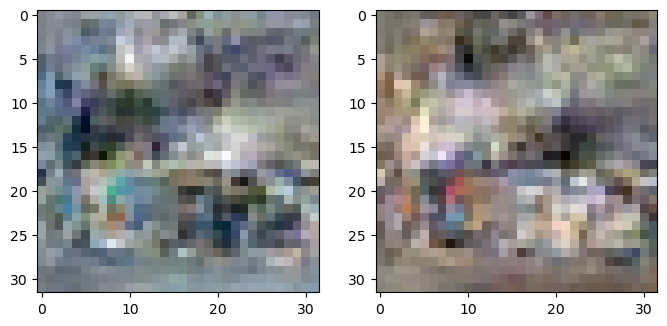

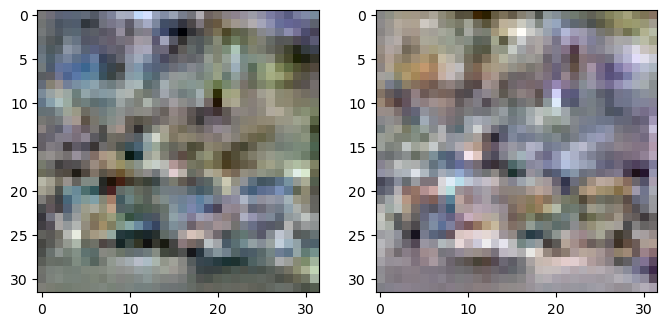

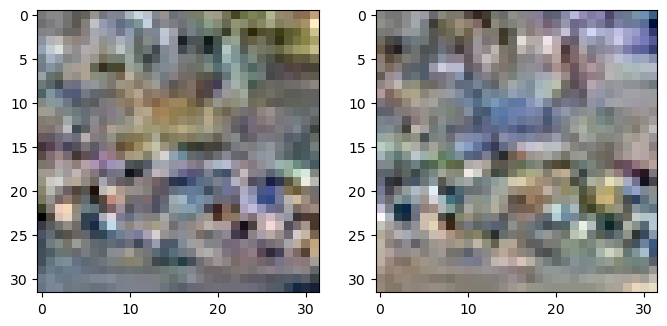

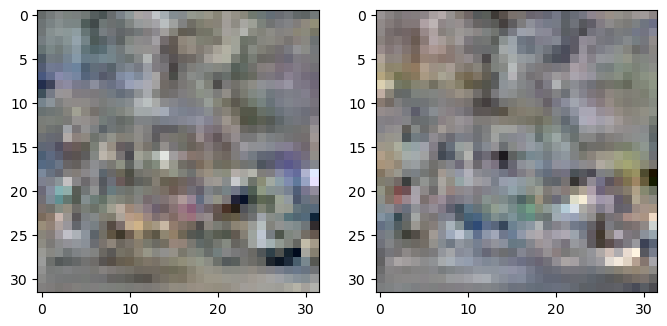

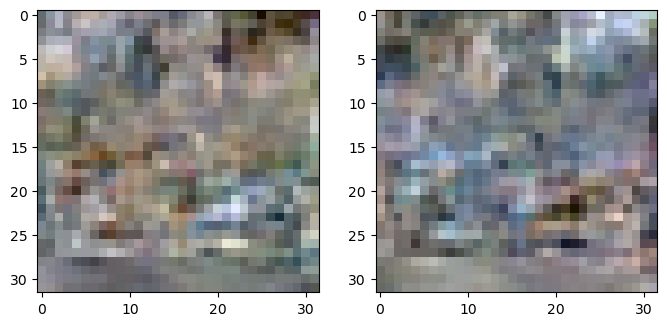

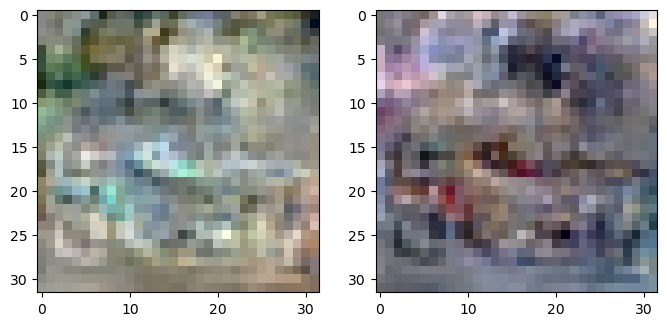

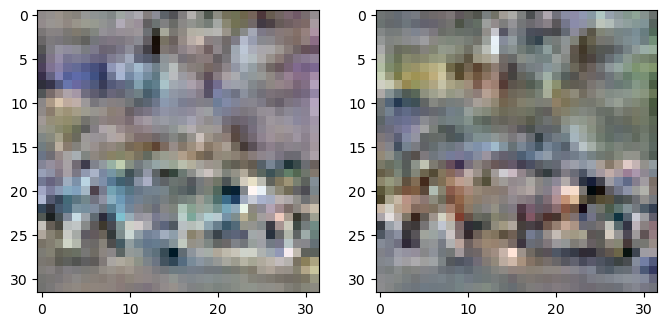

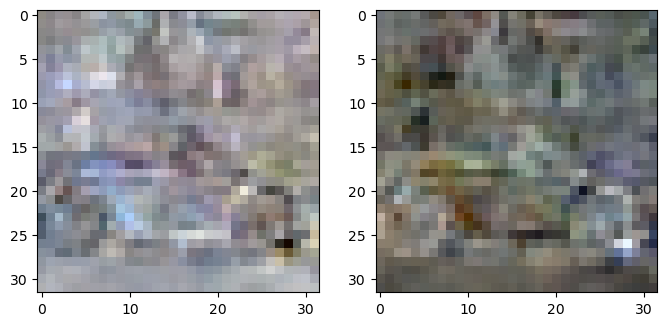

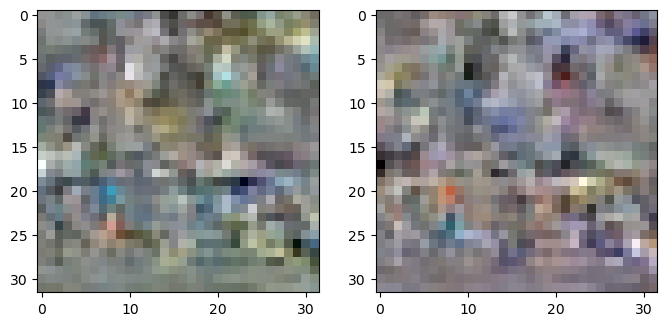

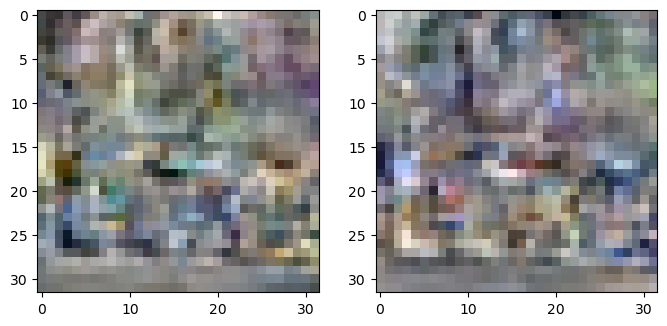

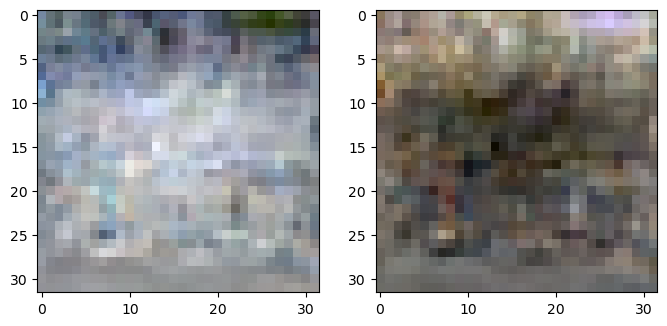

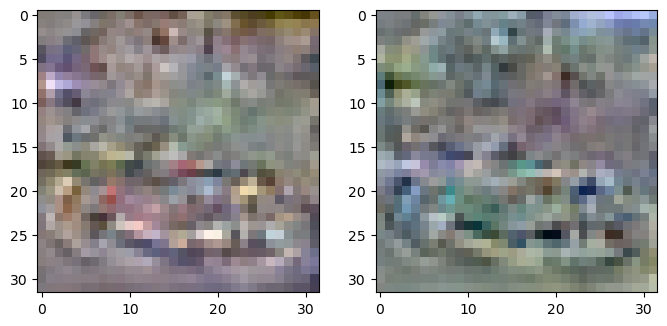

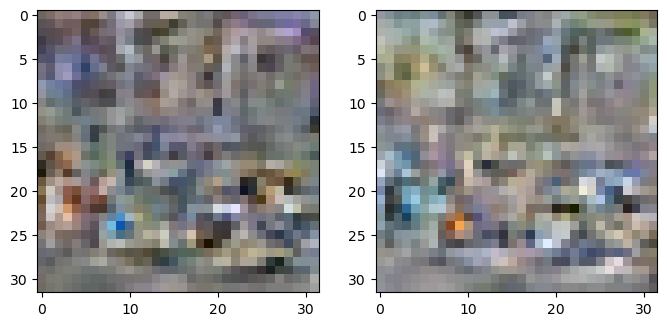

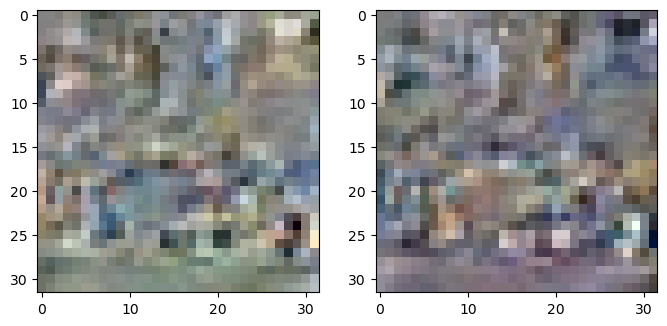

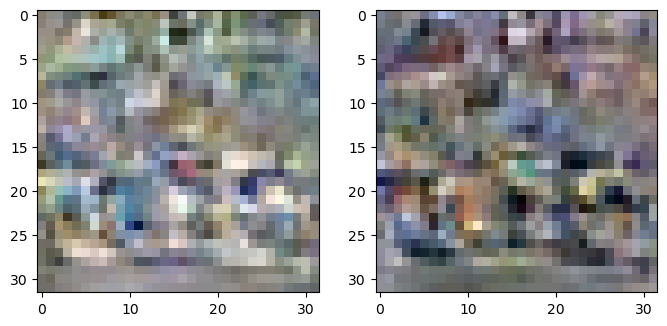

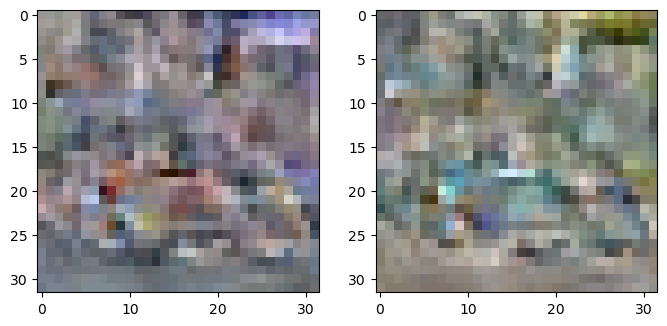

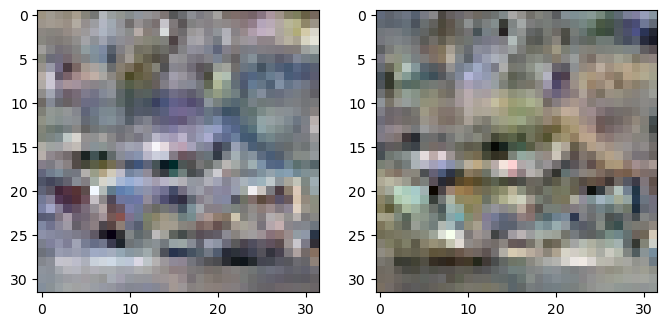

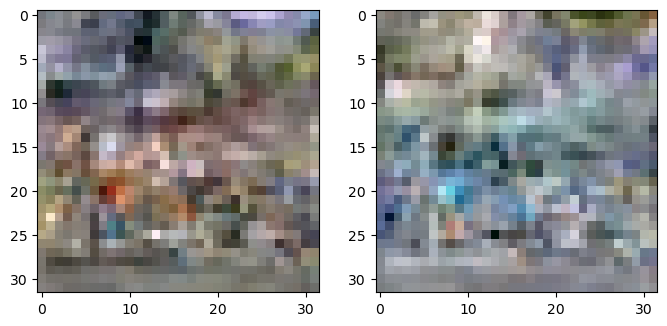

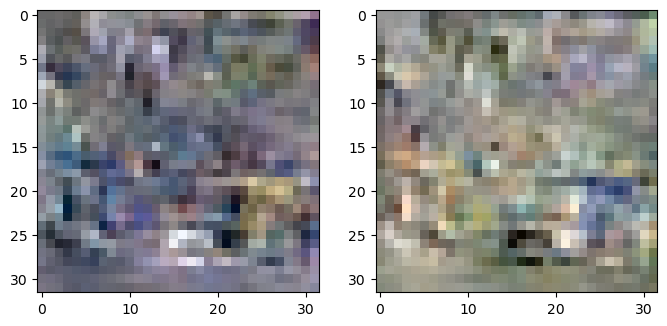

In [14]:
for i in range(128):
    with torch.no_grad():
        P = torch.permute((H[i] - mins[i]) / (maxs[i] - mins[i]), (1, 2, 0))
        P_ = 1.0 + -1.0 * P
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(P)
    axs[1].imshow(P_)
    plt.show()

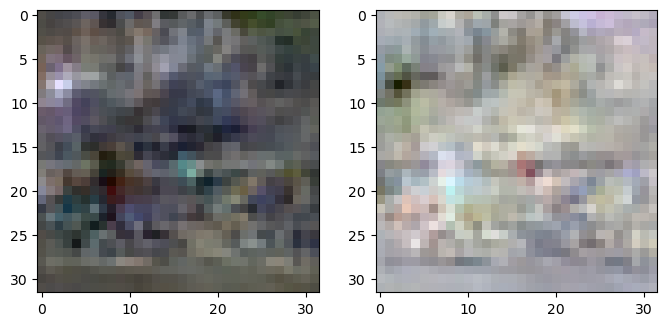

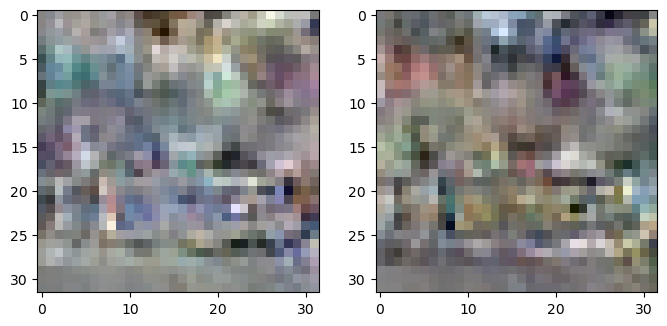

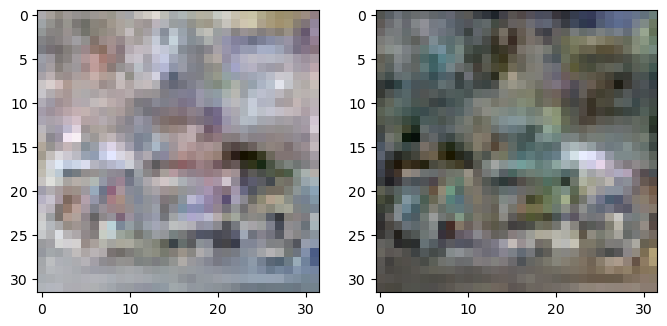

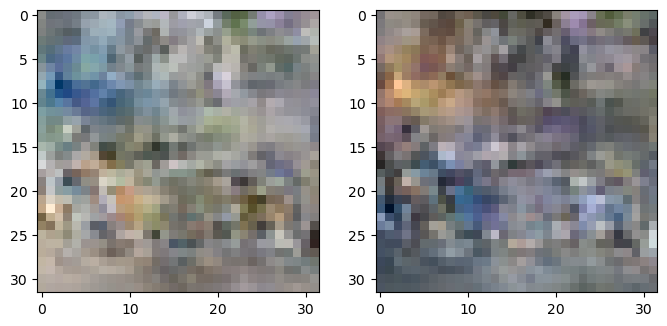

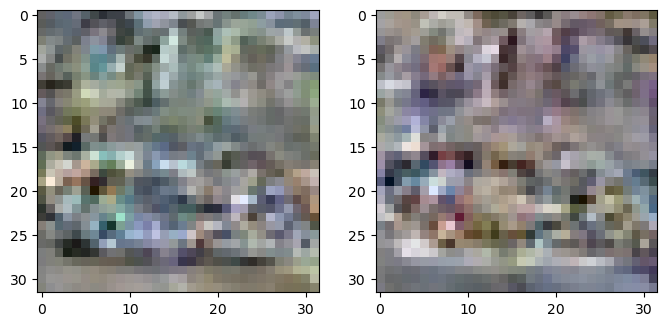

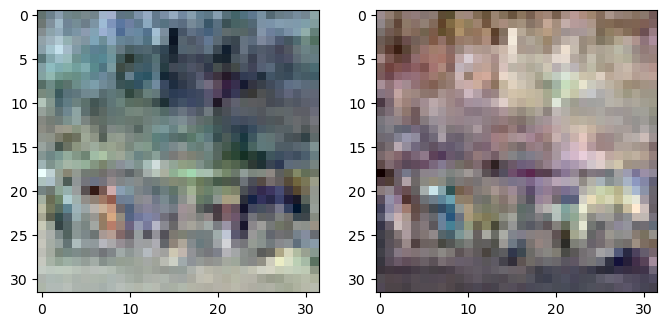

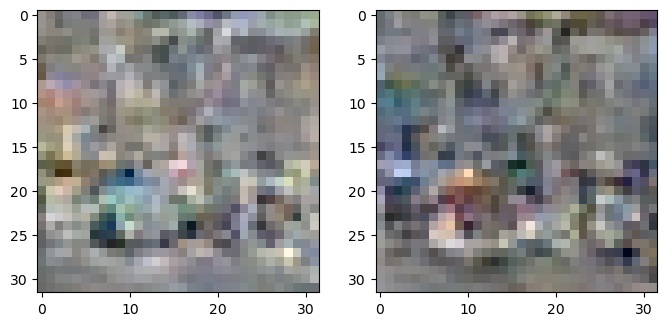

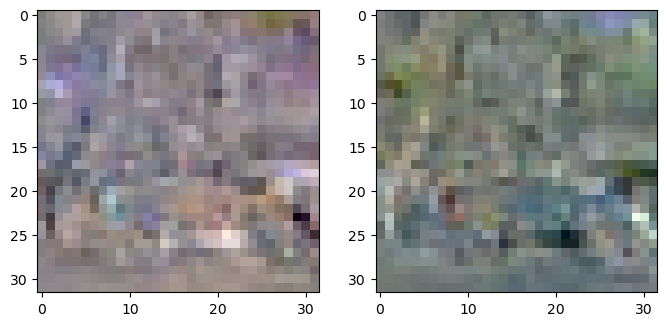

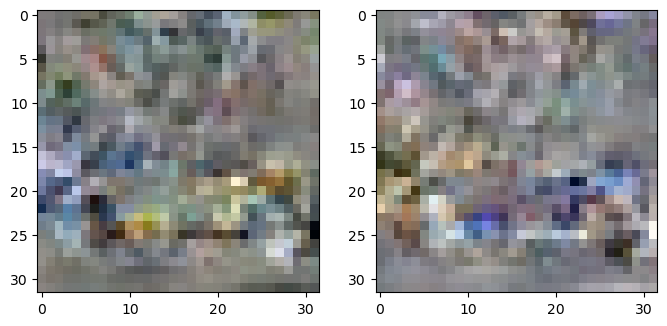

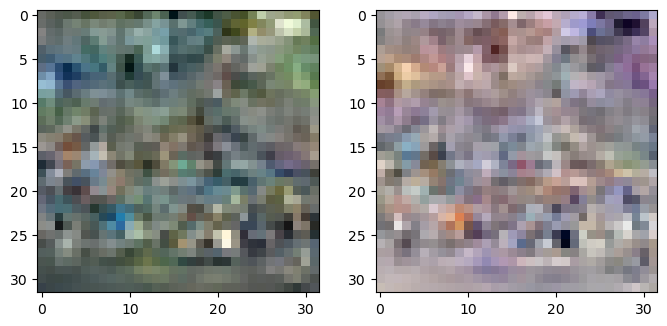

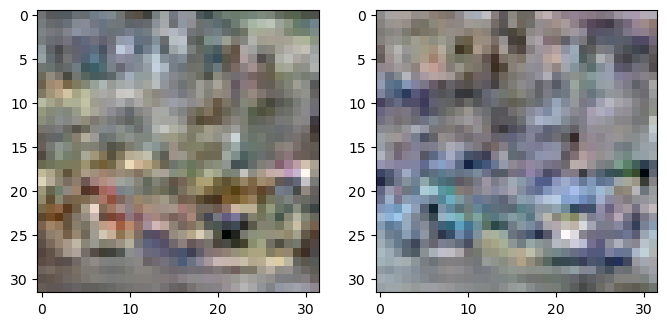

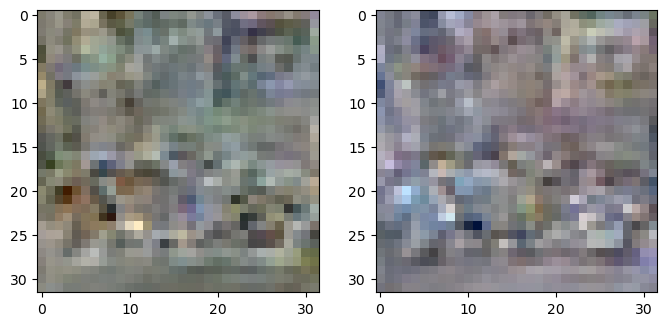

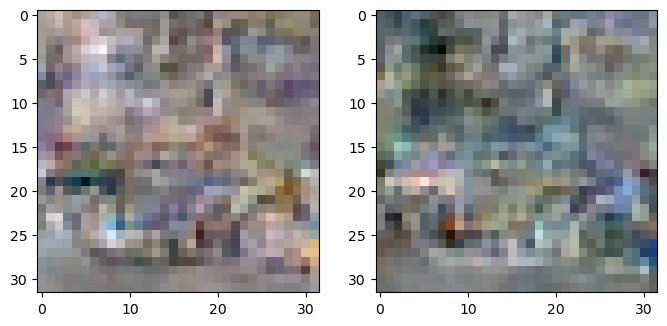

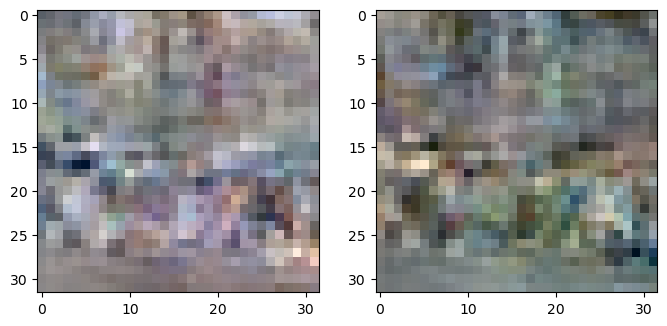

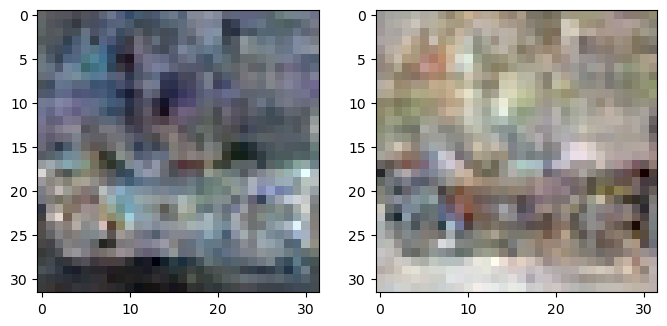

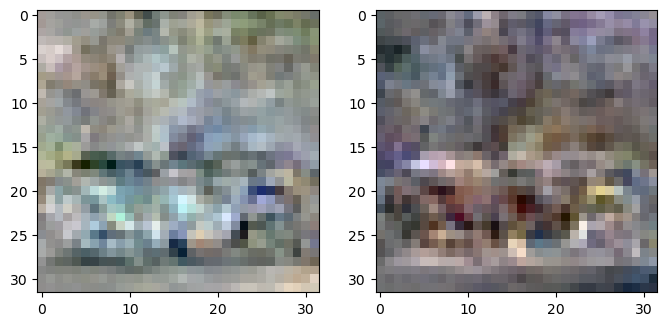

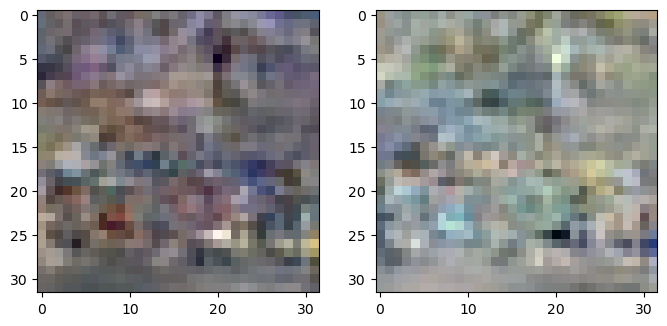

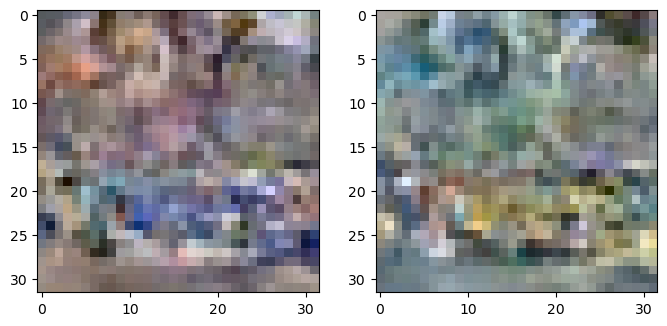

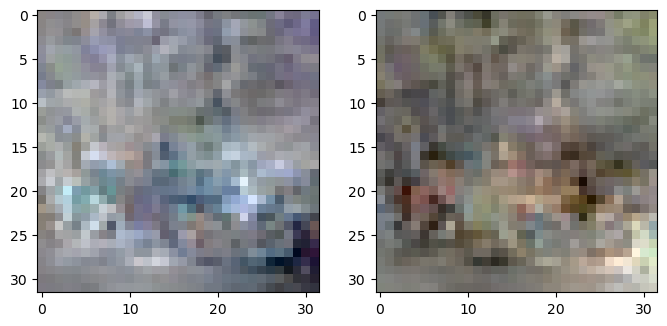

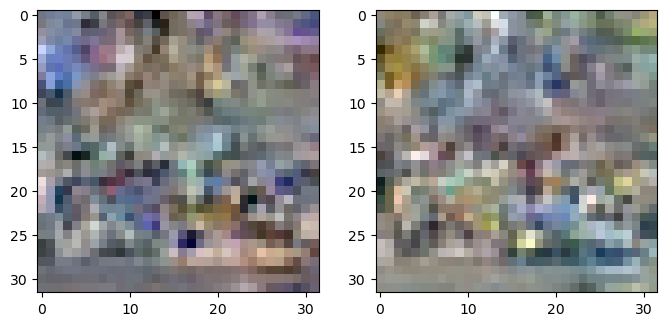

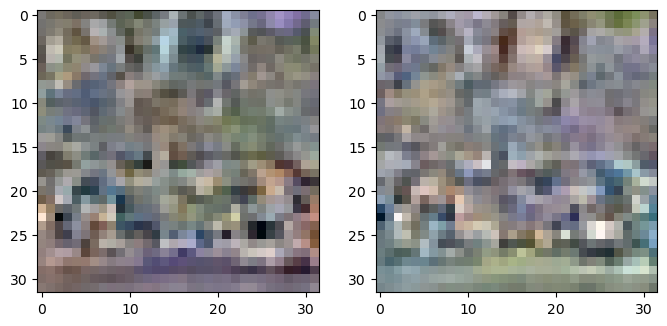

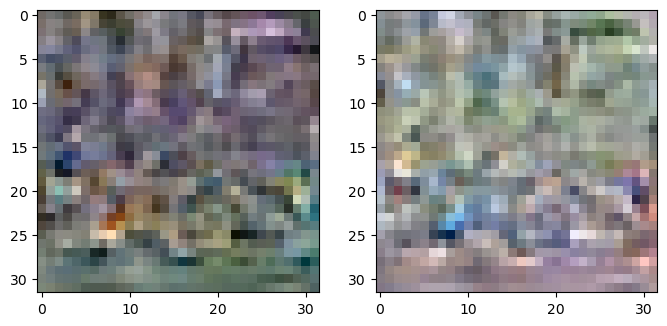

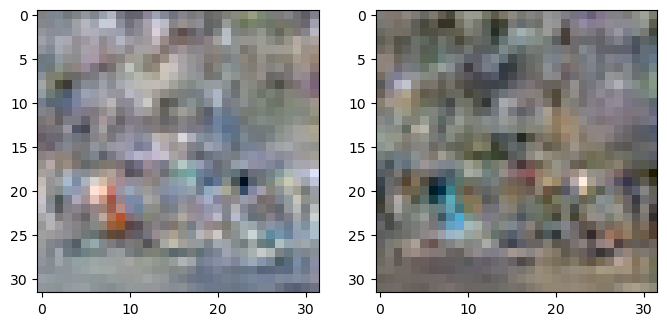

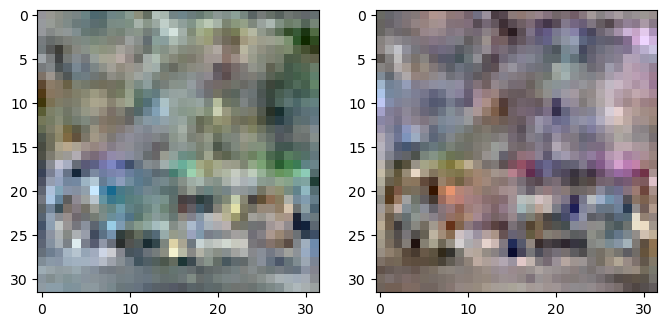

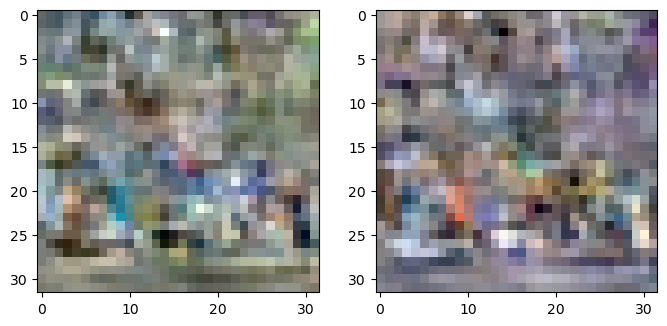

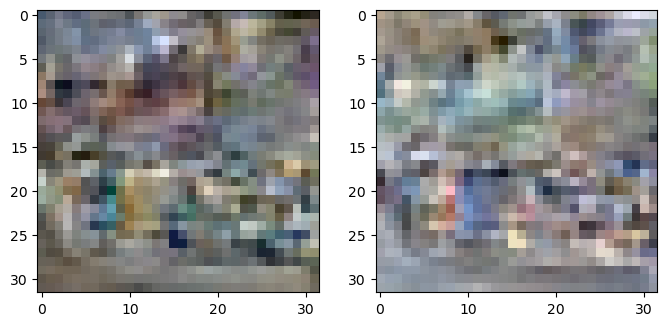

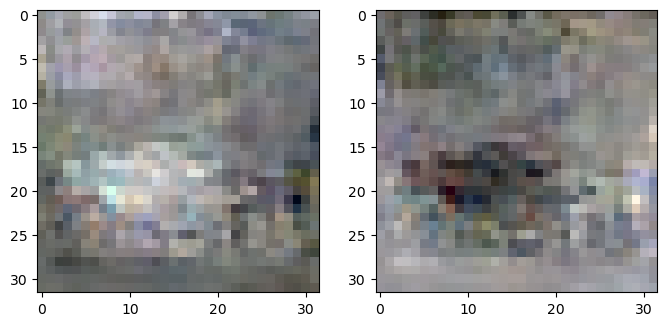

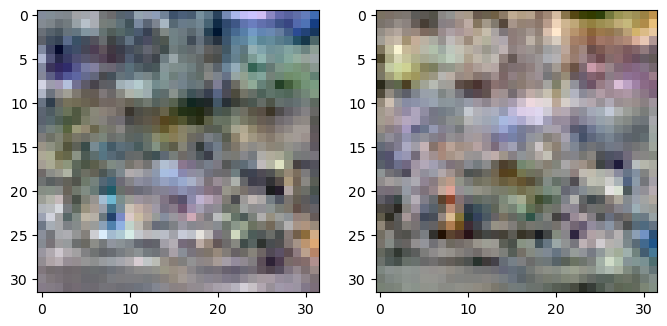

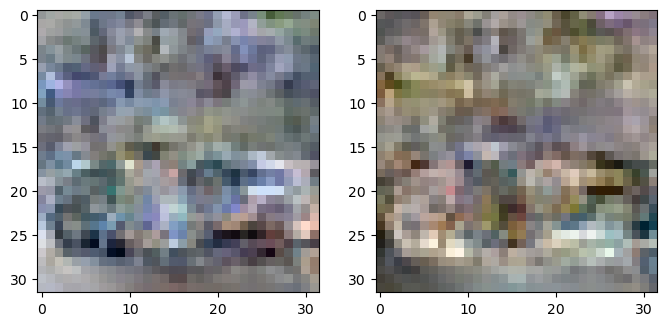

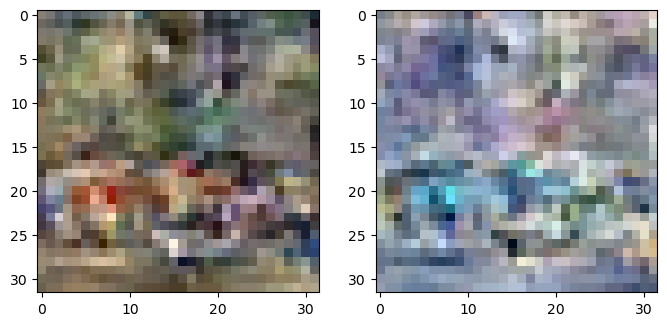

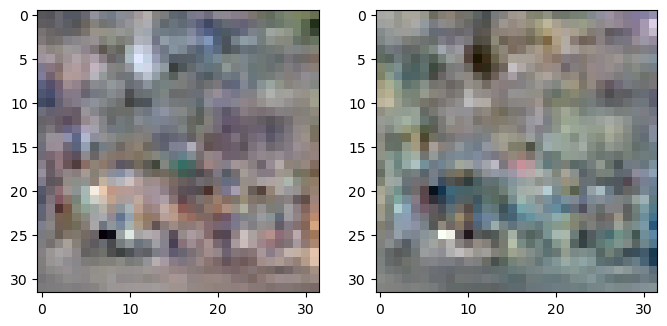

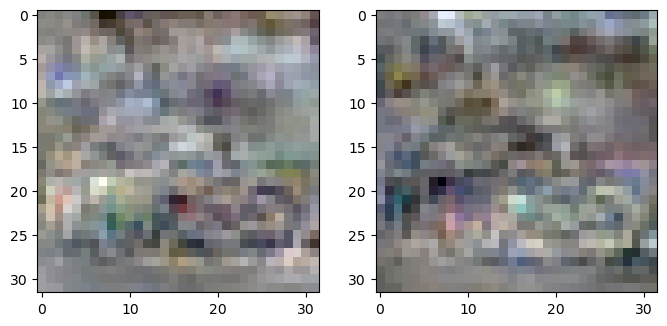

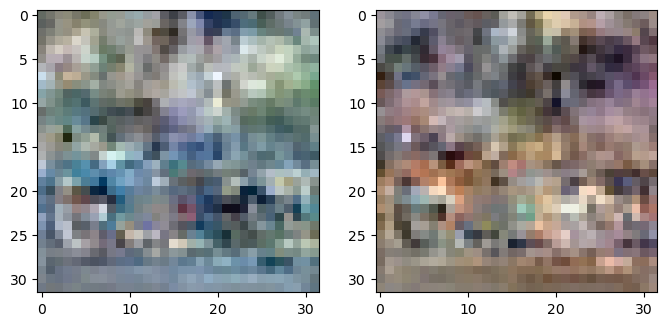

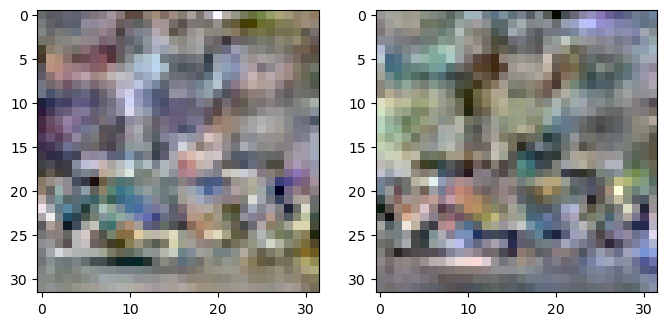

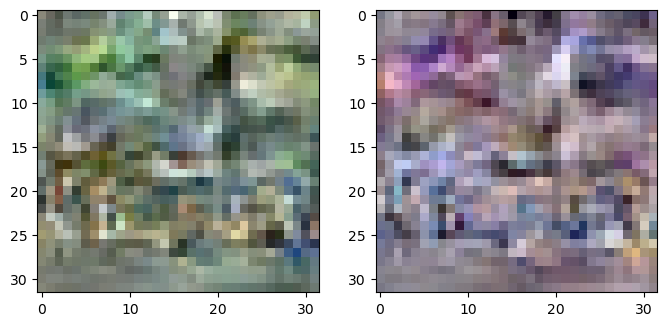

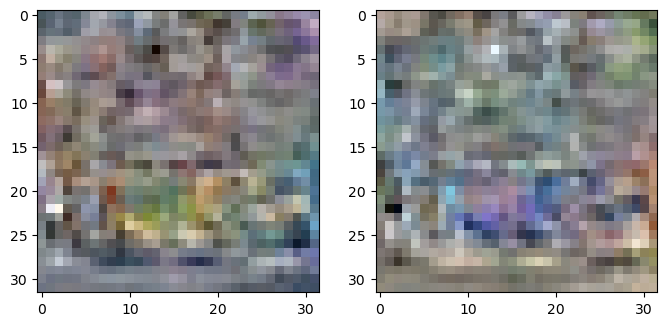

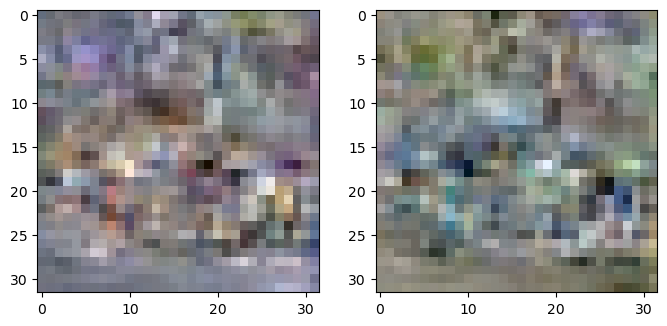

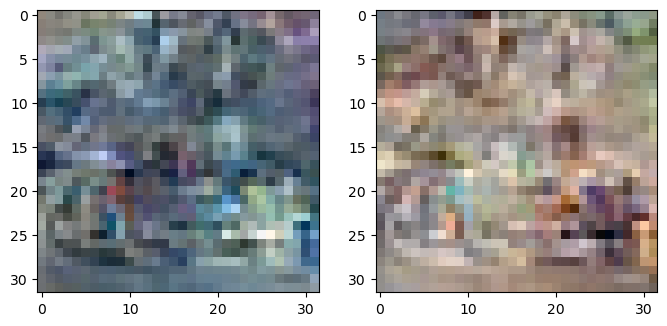

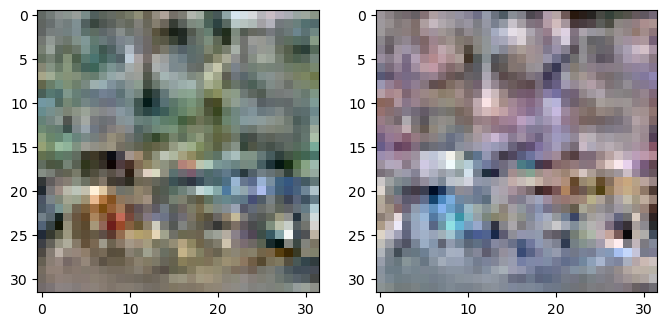

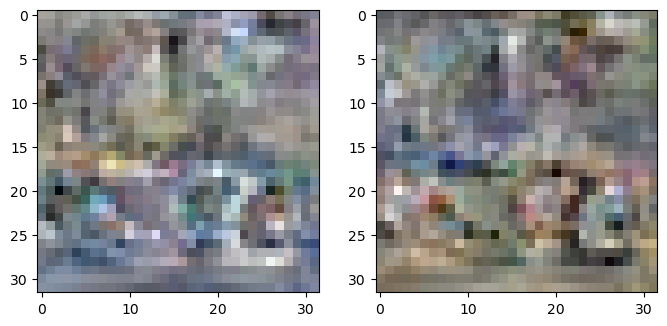

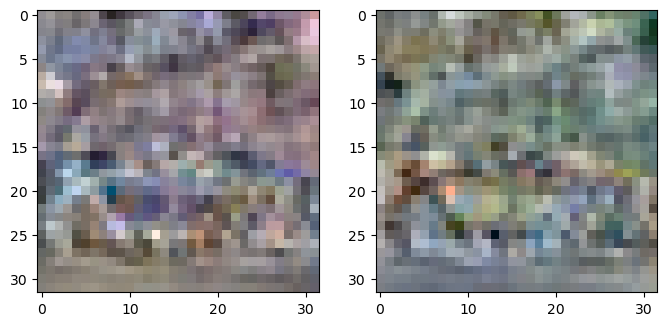

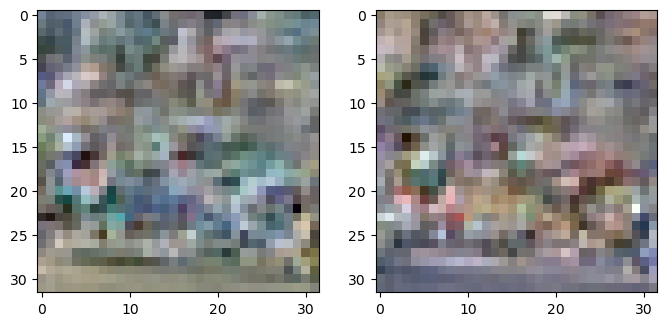

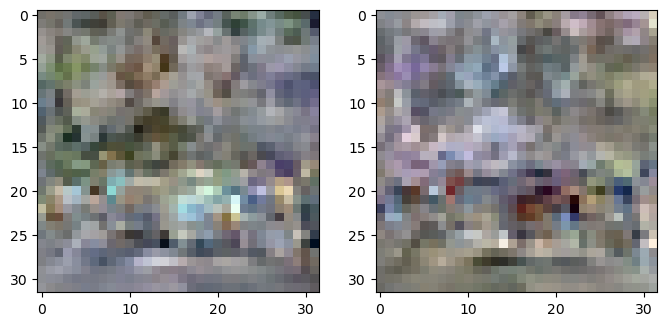

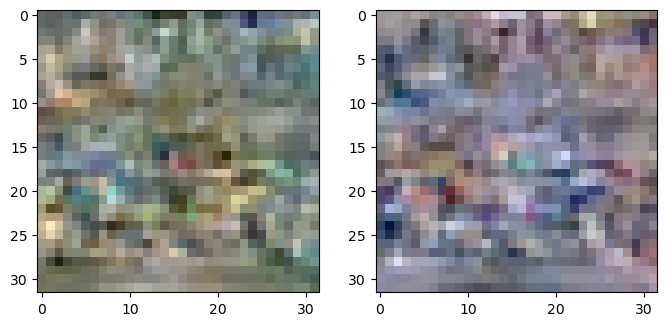

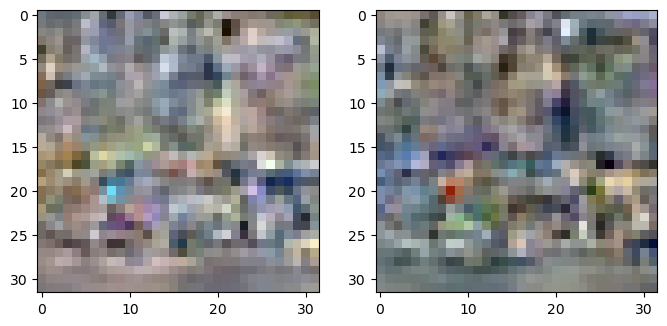

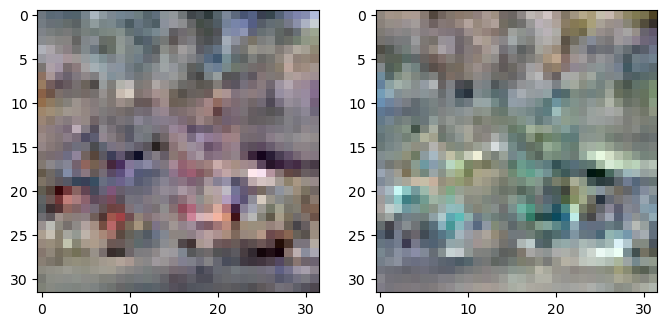

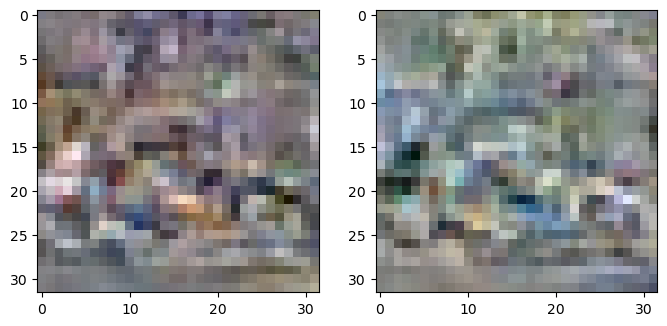

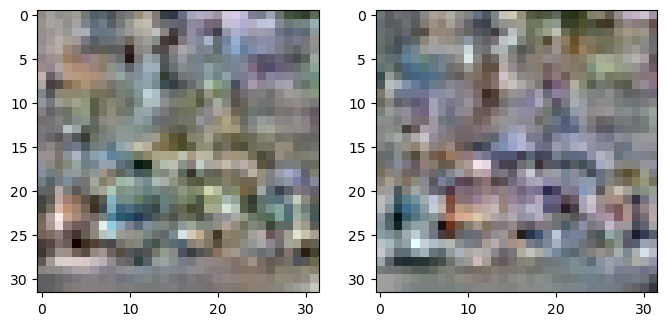

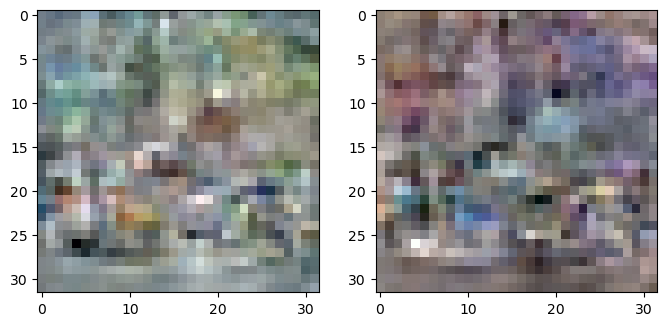

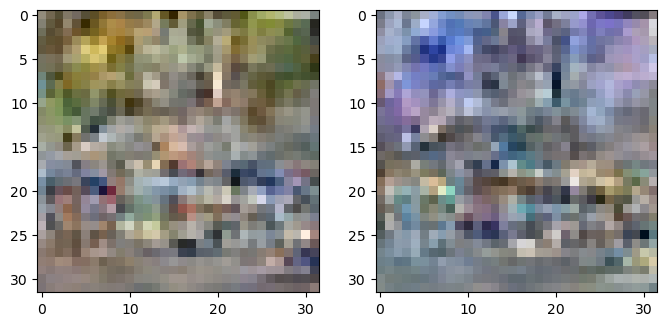

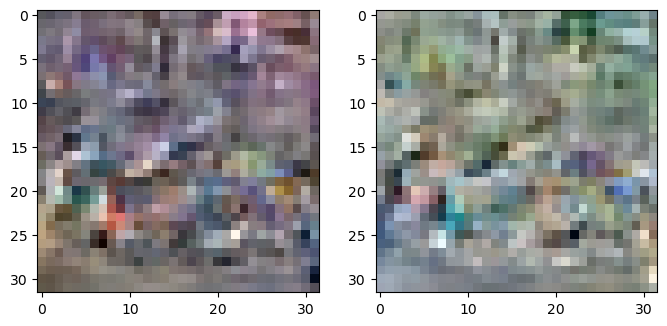

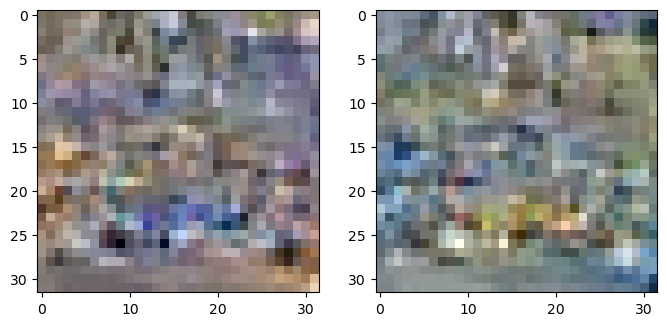

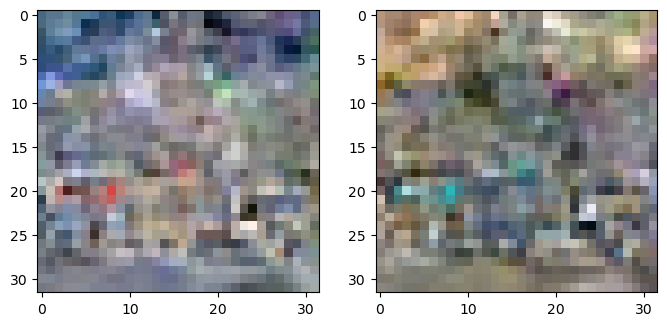

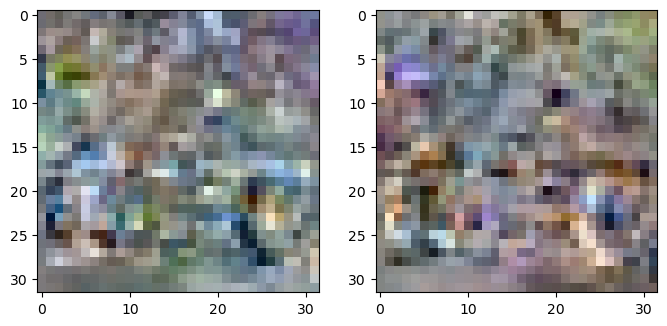

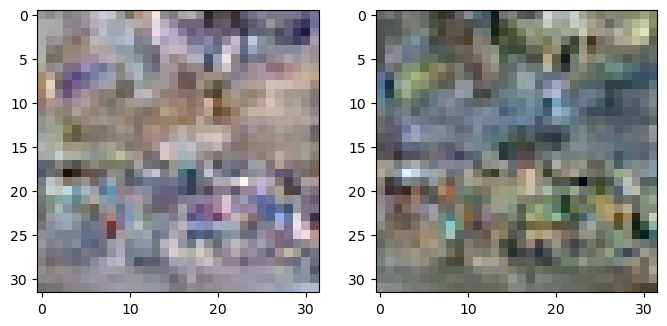

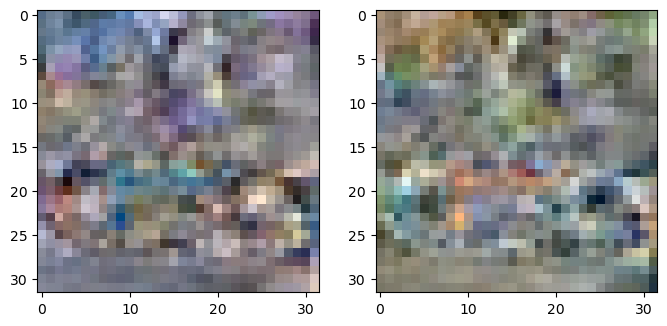

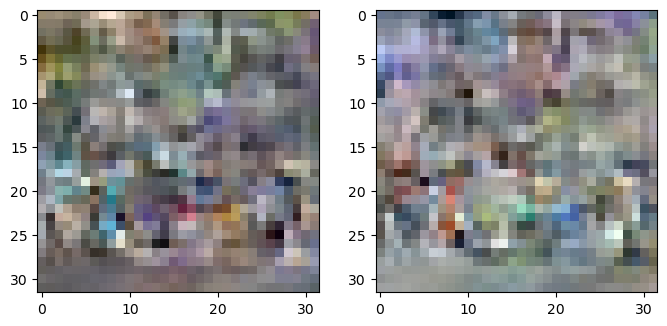

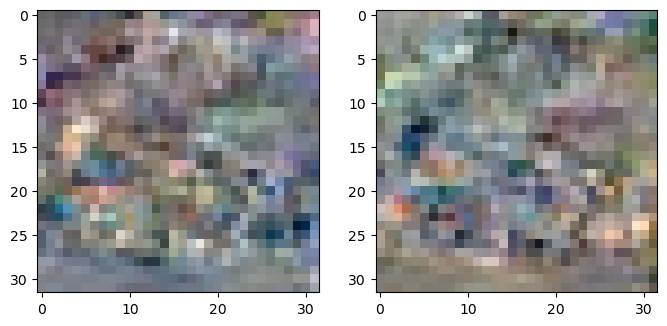

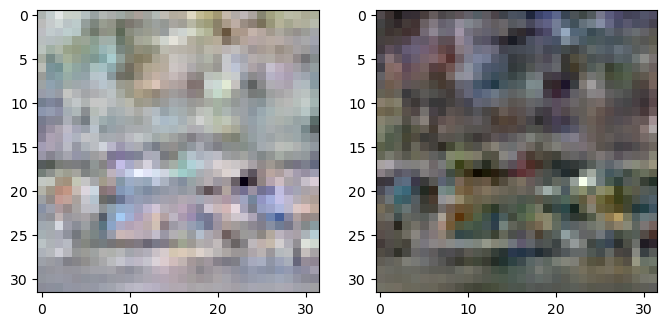

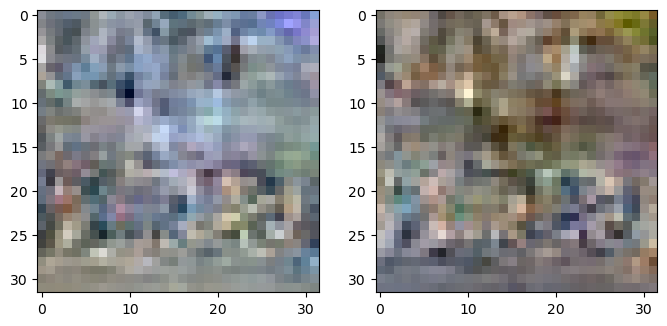

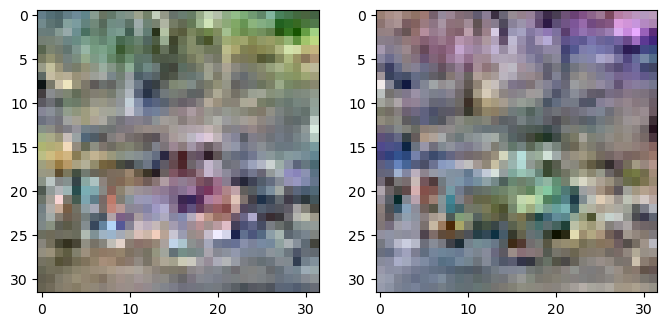

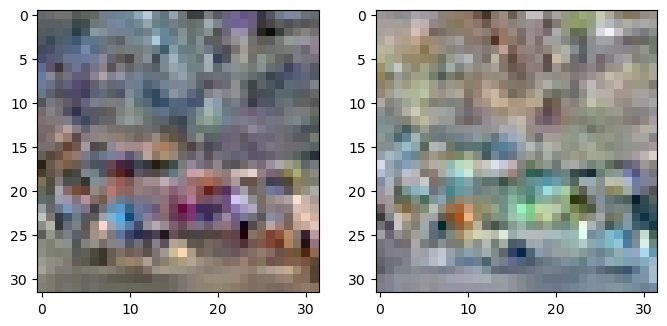

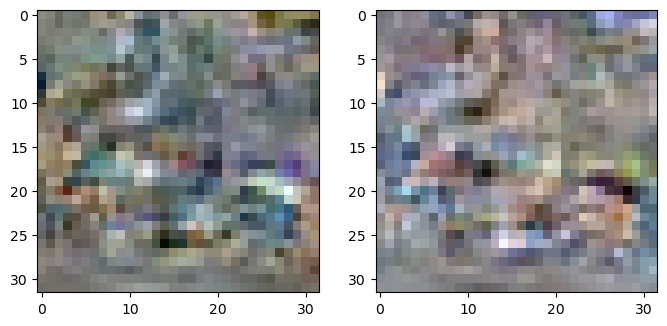

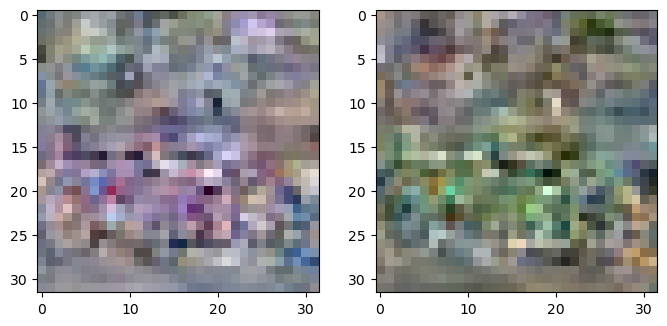

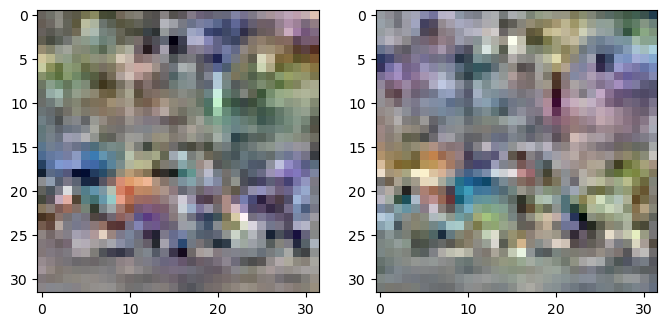

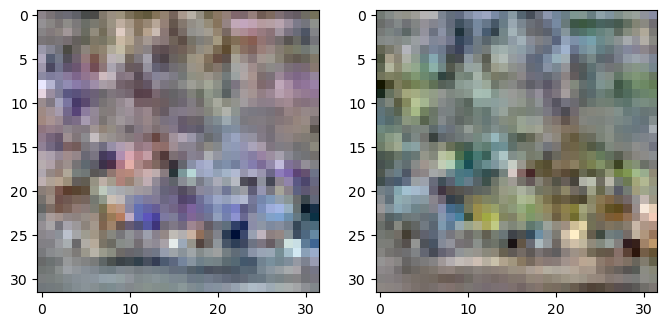

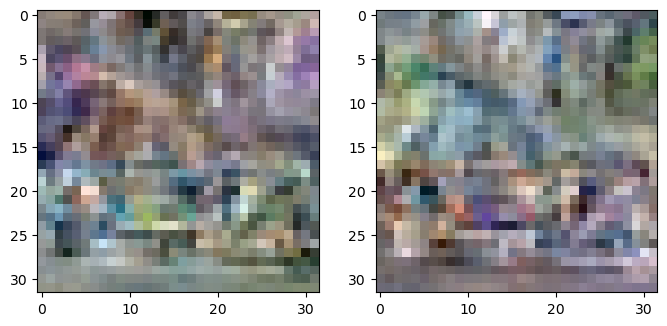

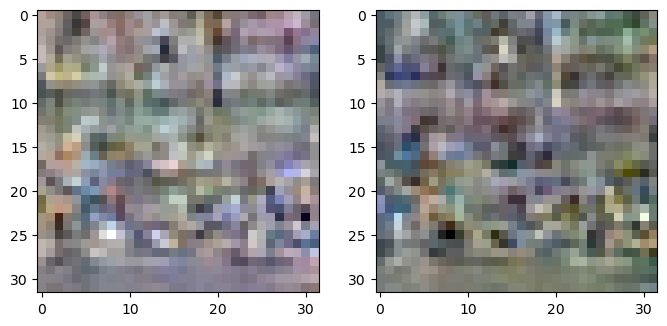

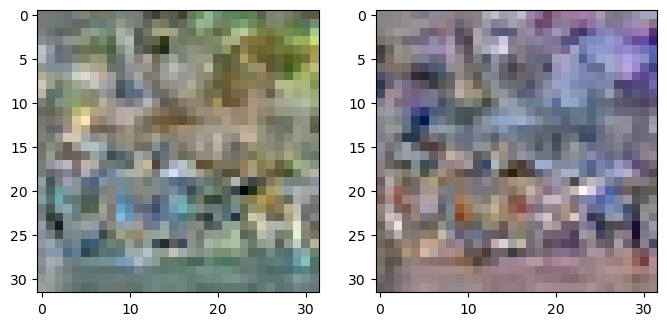

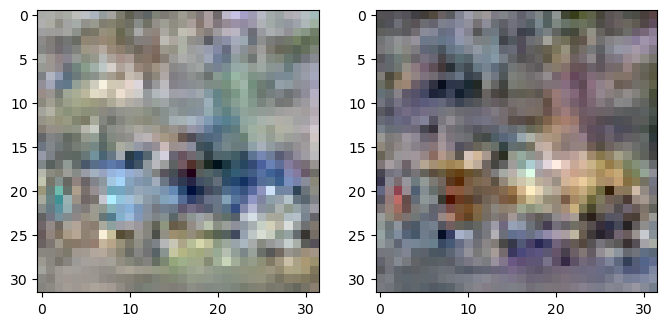

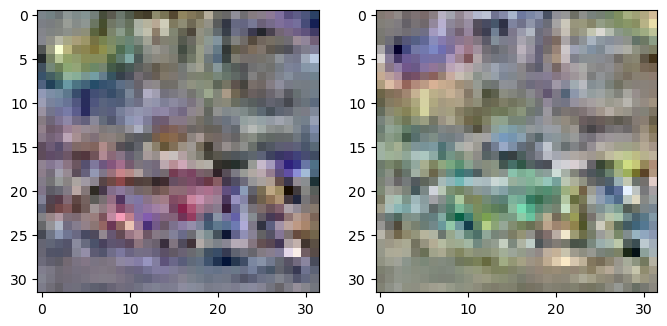

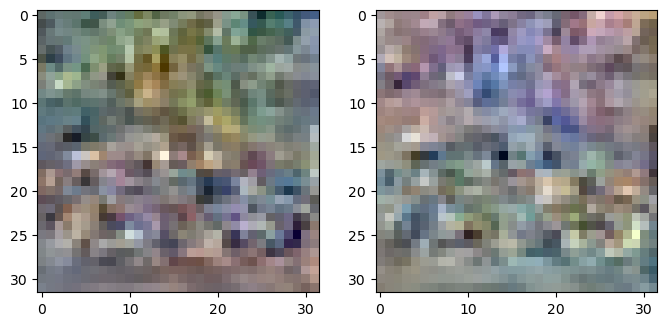

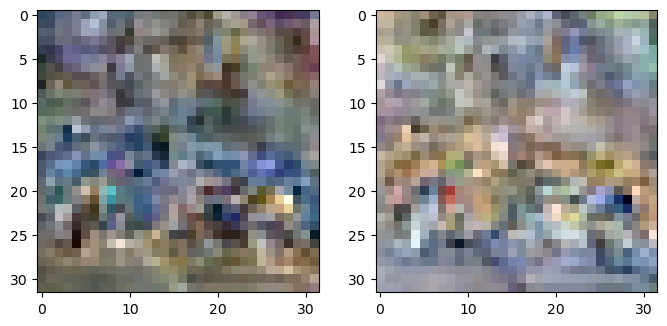

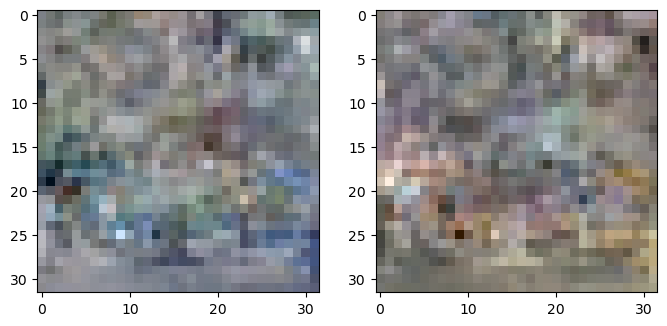

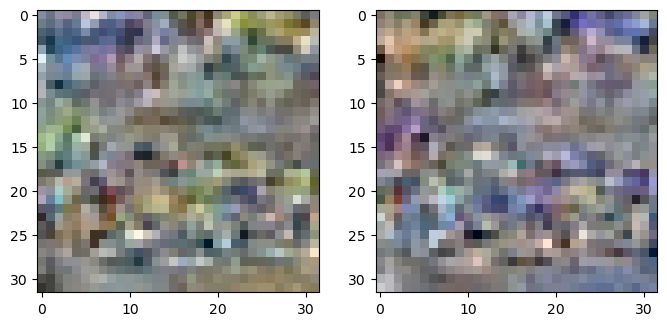

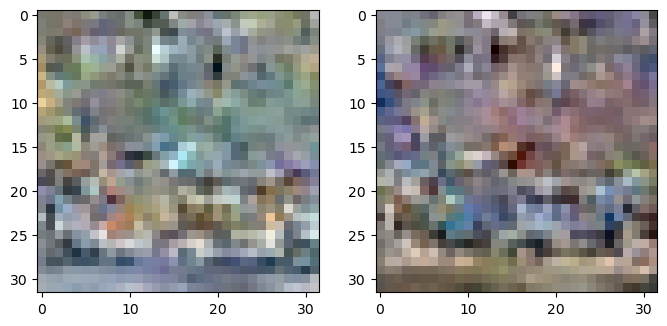

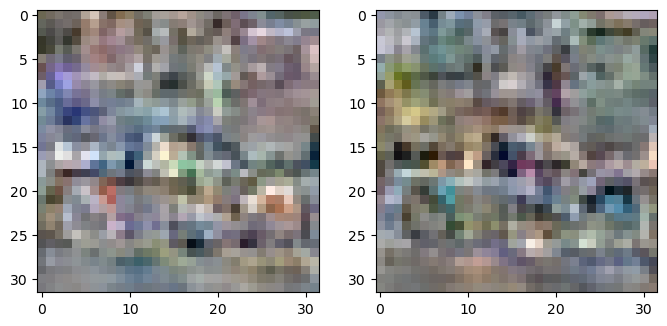

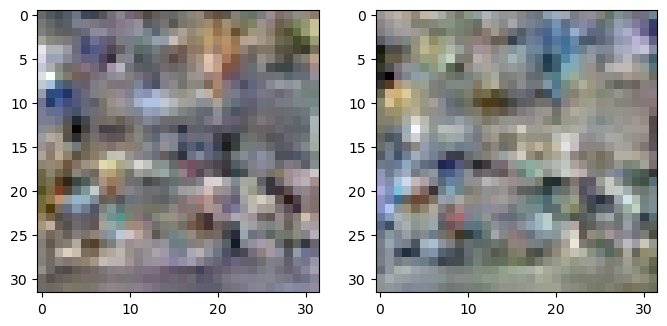

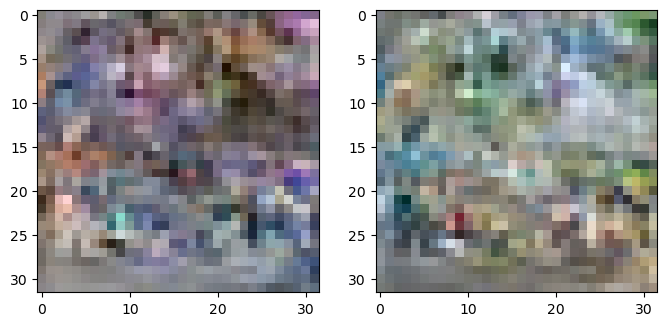

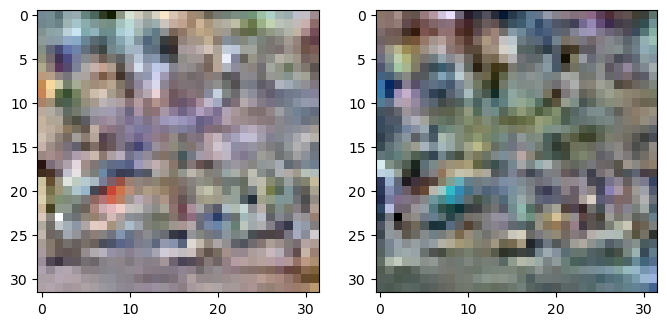

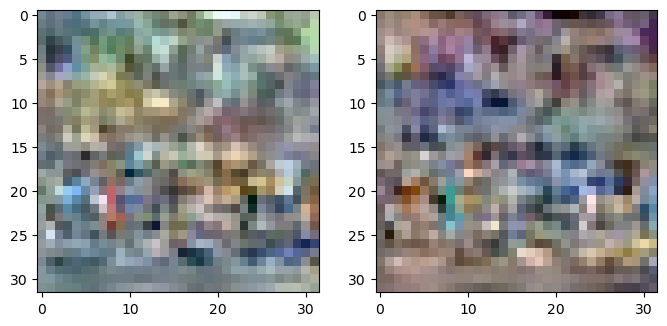

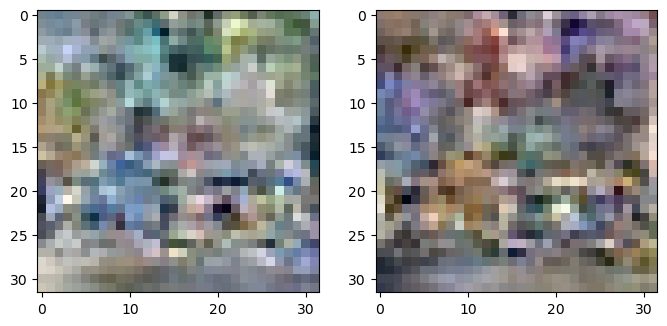

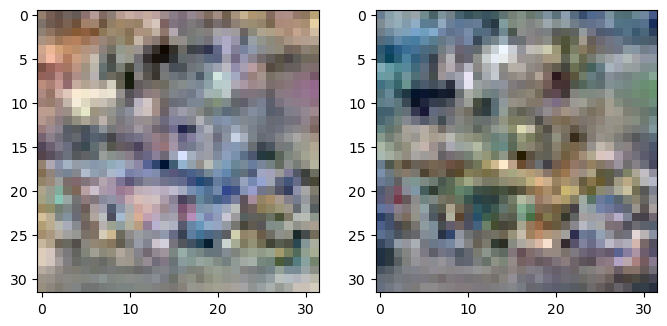

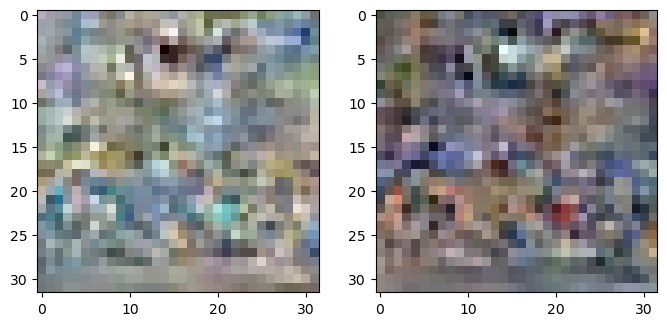

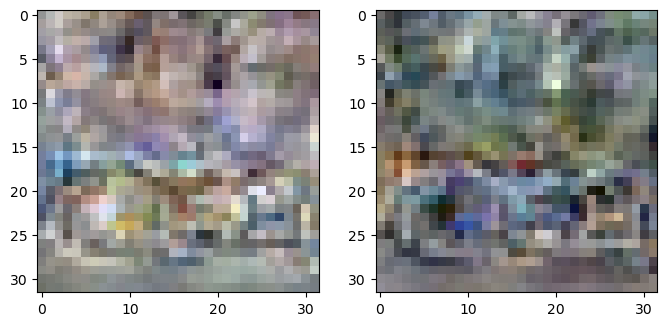

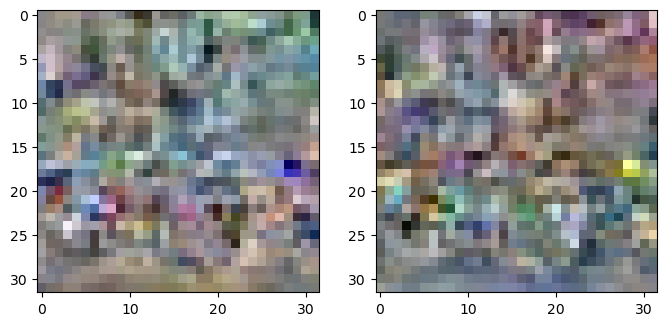

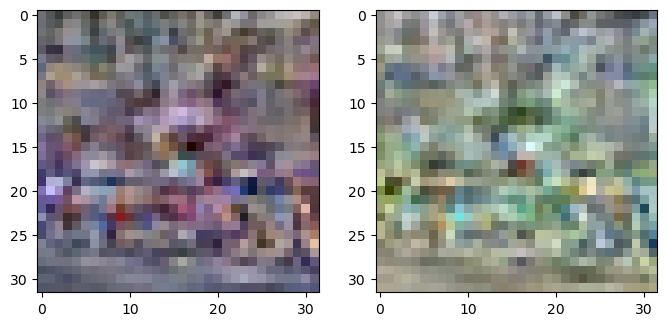

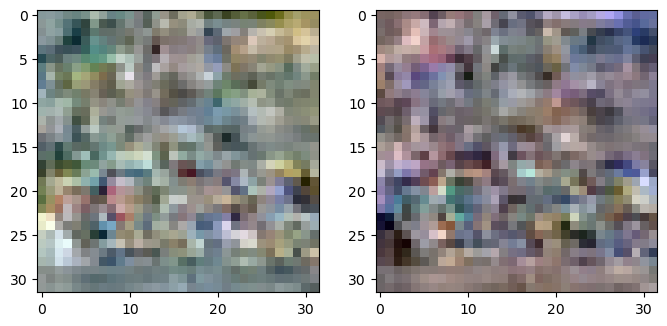

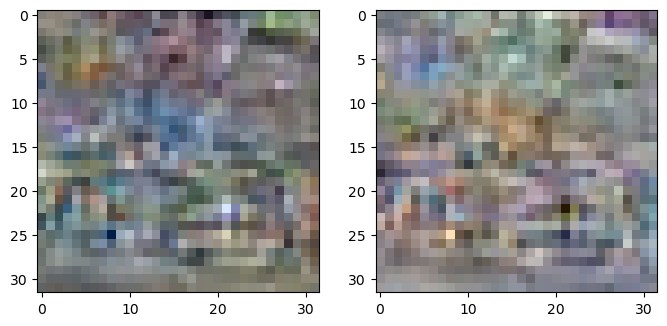

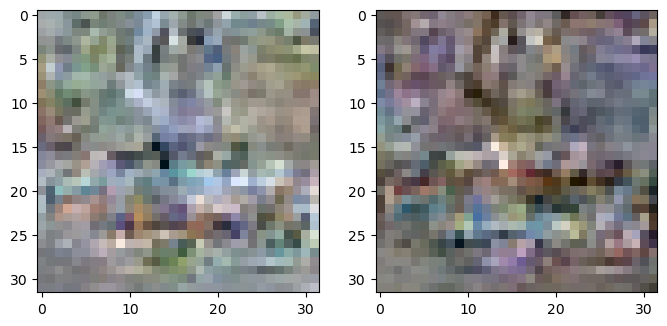

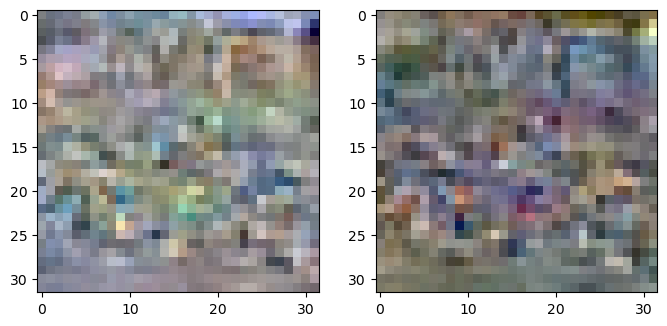

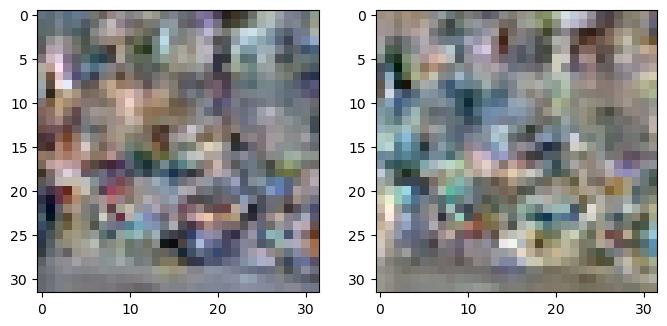

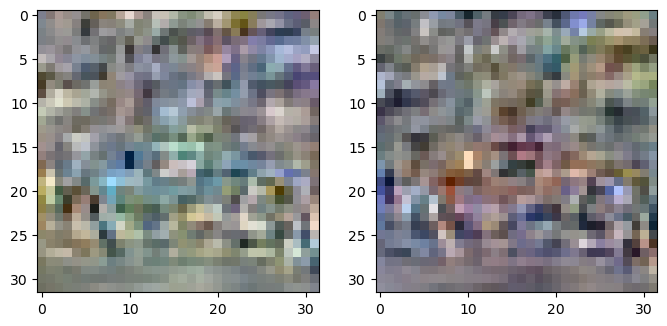

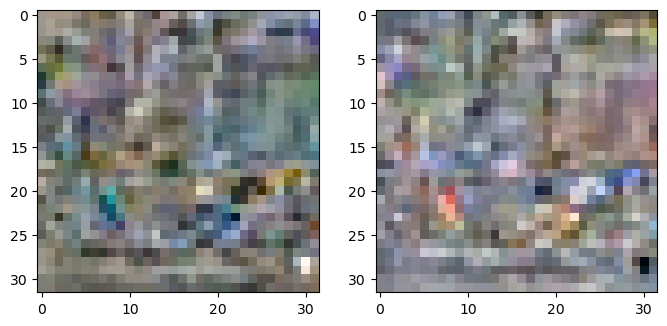

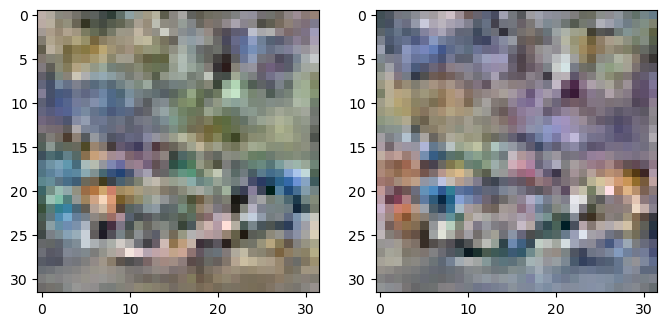

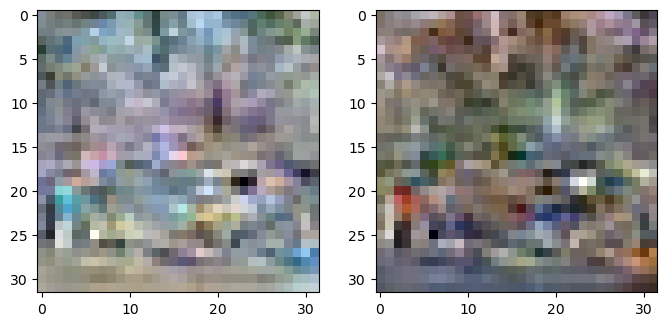

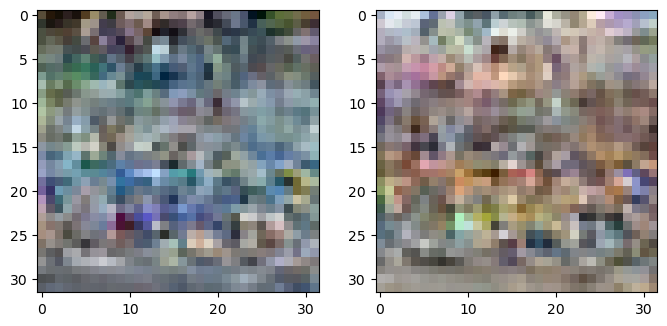

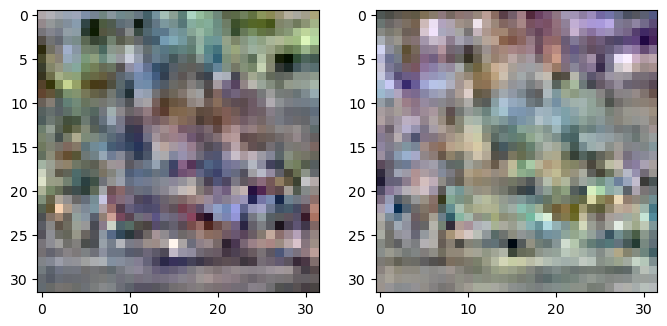

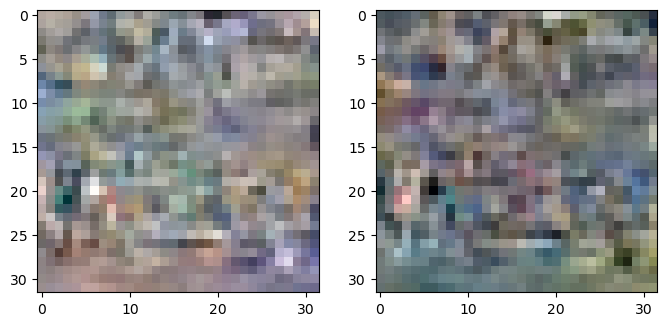

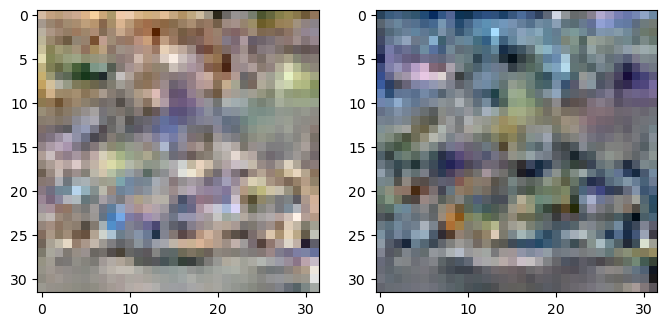

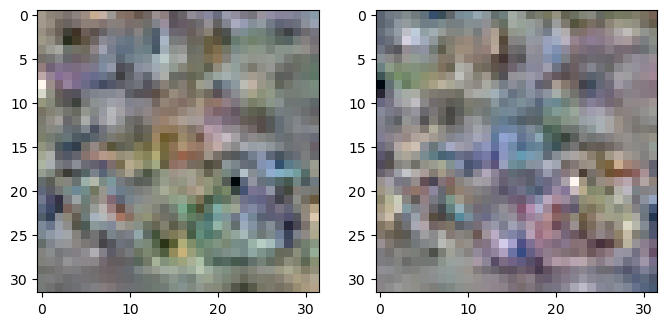

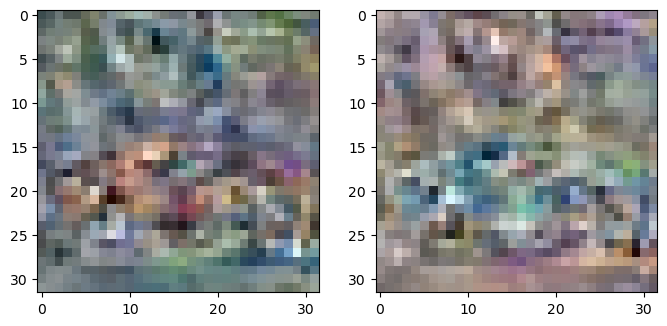

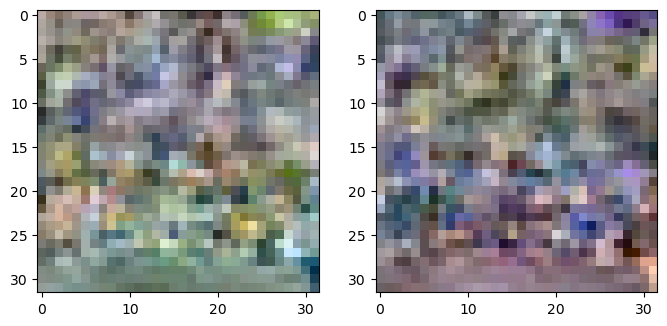

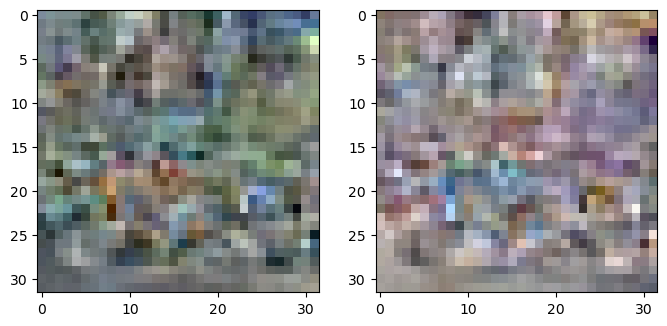

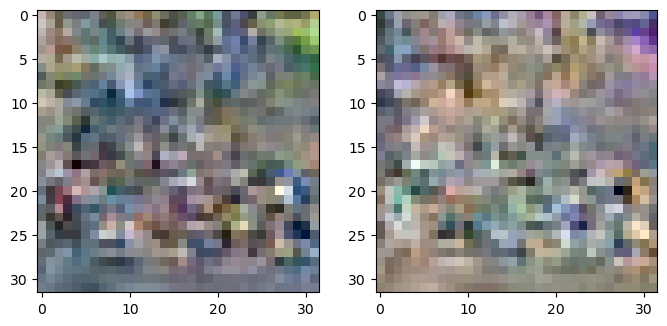

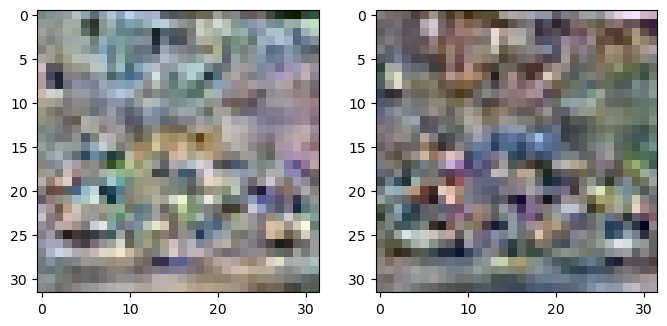

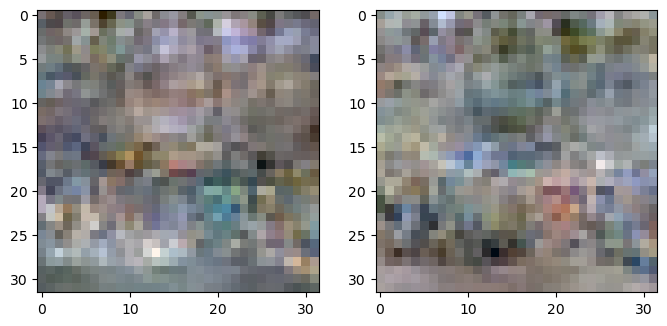

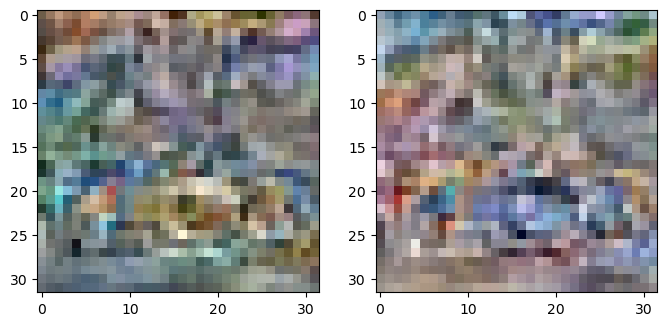

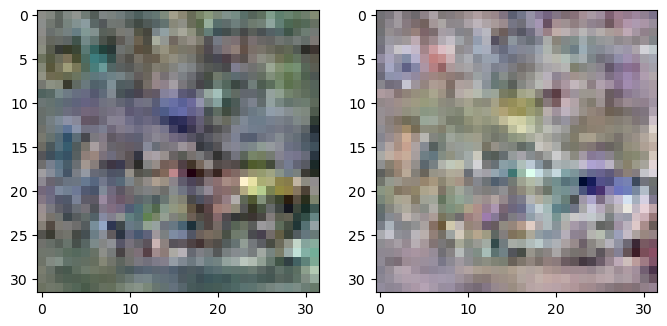

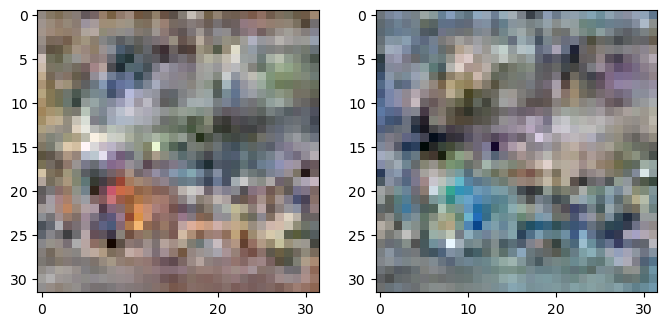

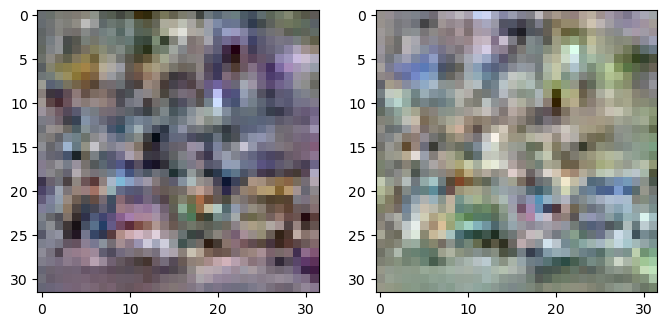

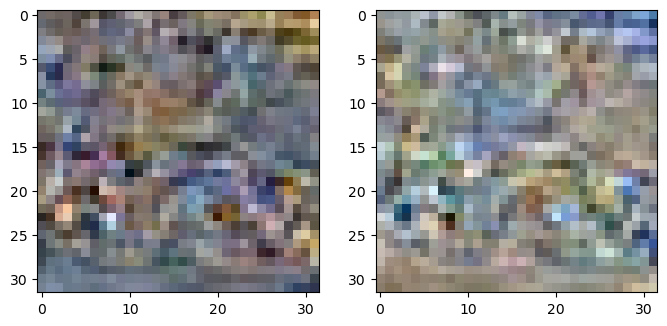

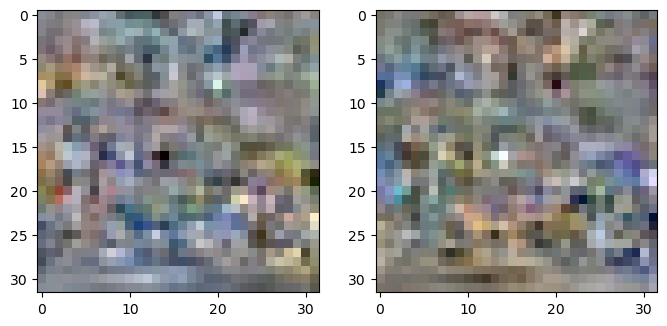

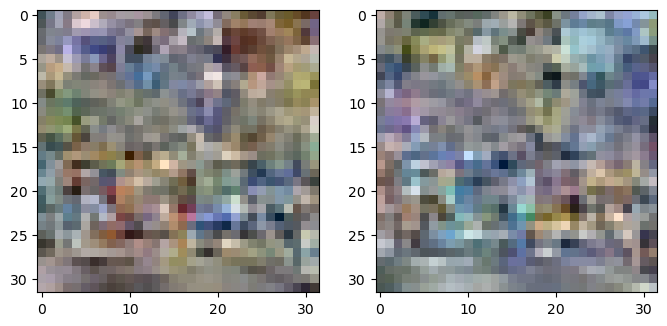

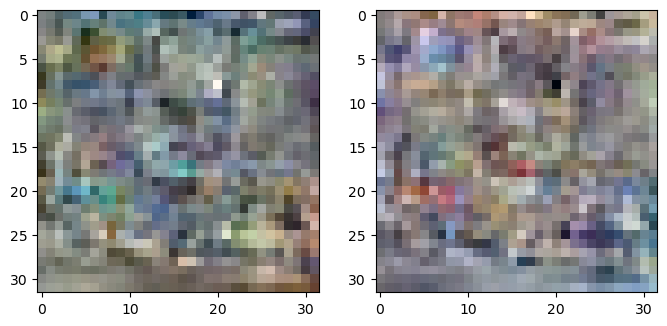

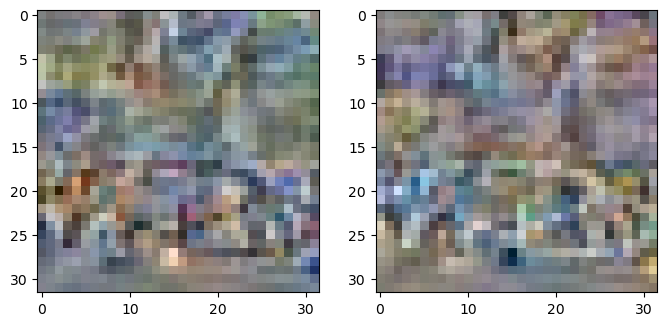

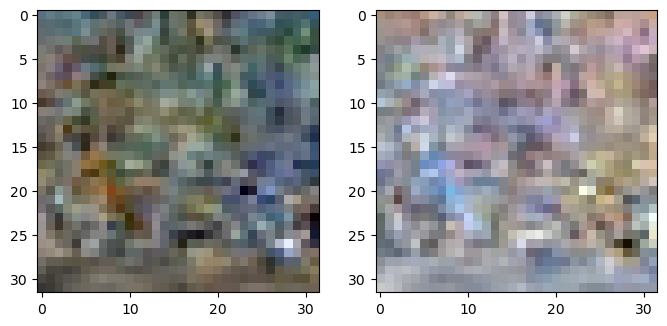

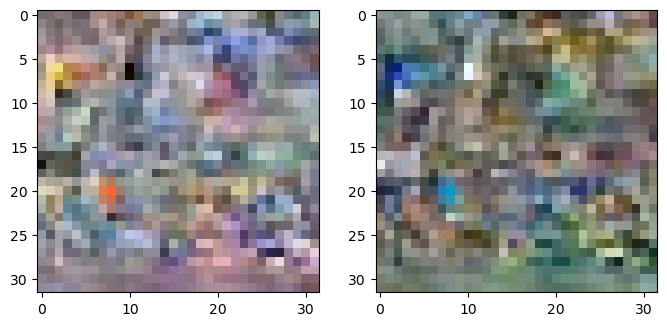

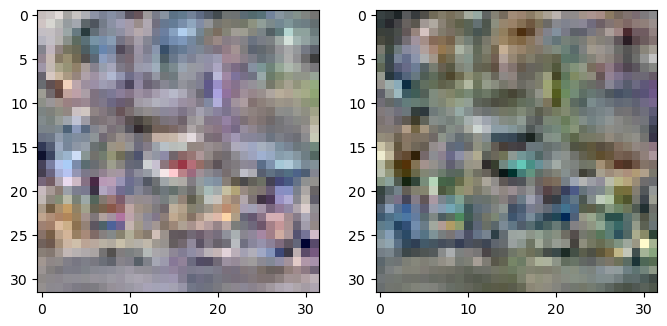

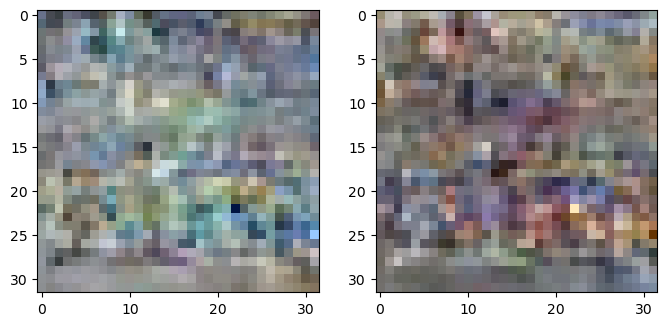

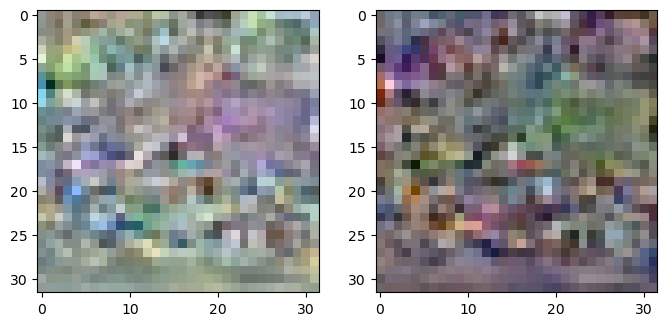

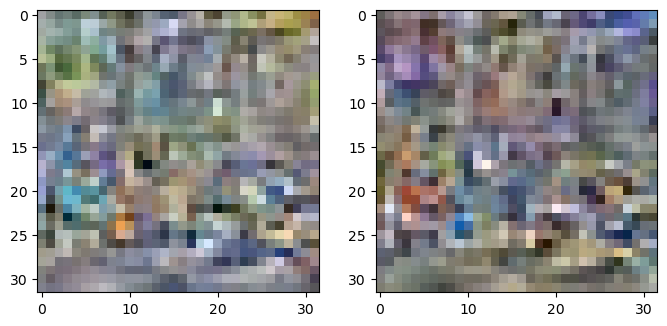

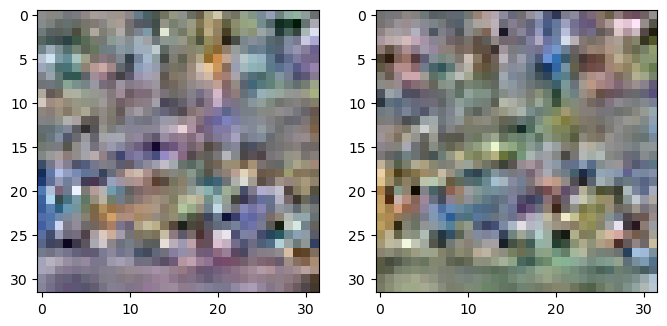

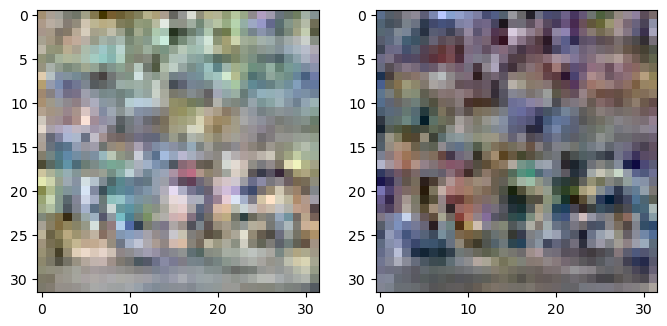

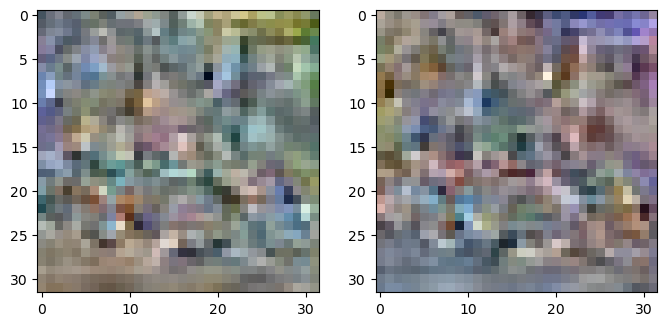

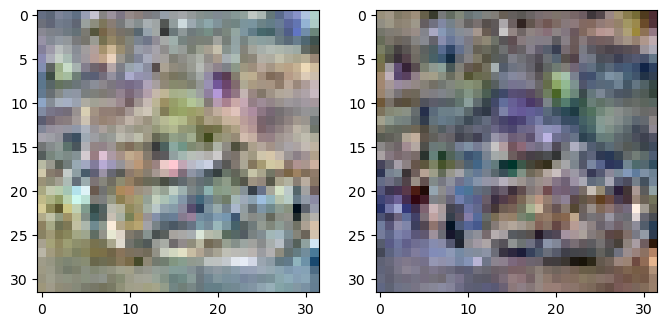

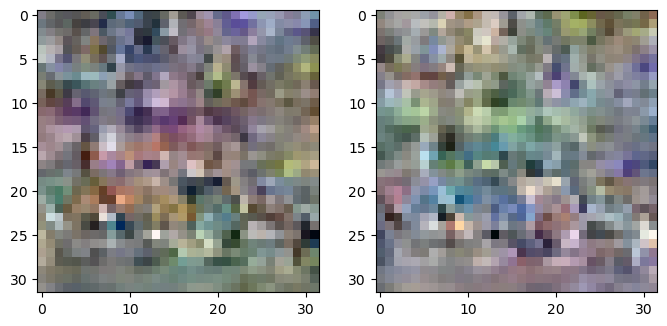

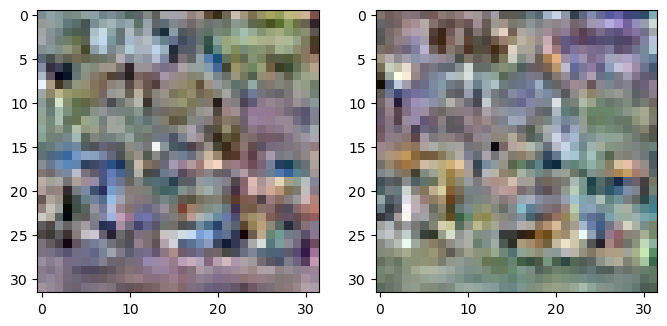

In [15]:
with torch.no_grad():
    Q, R = torch.linalg.qr(G)
    H = Q.T.resize(128, 3, 32, 32)

maxs = H.max(-1).values.max(-1).values.max(-1).values
mins = H.min(-1).values.min(-1).values.min(-1).values

for i in range(128):
    with torch.no_grad():
        P = torch.permute((H[i] - mins[i]) / (maxs[i] - mins[i]), (1, 2, 0))
        P_ = 1.0 + -1.0 * P
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(P)
    axs[1].imshow(P_)
    plt.show()

In [16]:
torch.diag(R) ** 2 / (R**2).sum(0)

tensor([1.0000, 0.9916, 0.9997, 0.9663, 0.9857, 0.9762, 0.9929, 0.9793, 0.9837,
        0.9393, 0.9806, 0.9666, 0.9521, 0.9506, 0.8767, 0.9410, 0.9222, 0.9263,
        0.9080, 0.9338, 0.9436, 0.9274, 0.8877, 0.8458, 0.9158, 0.8690, 0.7946,
        0.9004, 0.8436, 0.8963, 0.9062, 0.8596, 0.8526, 0.8785, 0.8359, 0.8458,
        0.8417, 0.7579, 0.9072, 0.8558, 0.8558, 0.8930, 0.8120, 0.7989, 0.8441,
        0.7277, 0.8524, 0.8582, 0.8217, 0.6759, 0.8569, 0.8848, 0.7336, 0.7837,
        0.7422, 0.6341, 0.8186, 0.8327, 0.8706, 0.5548, 0.7343, 0.7867, 0.8184,
        0.7368, 0.8096, 0.8637, 0.6543, 0.7731, 0.6894, 0.7366, 0.7725, 0.7485,
        0.6988, 0.6580, 0.7487, 0.7789, 0.8245, 0.8279, 0.4582, 0.7396, 0.7020,
        0.7795, 0.6346, 0.6607, 0.7234, 0.6993, 0.6622, 0.6798, 0.7203, 0.5596,
        0.6926, 0.7599, 0.7012, 0.7476, 0.6407, 0.5548, 0.2293, 0.7527, 0.7063,
        0.1615, 0.7228, 0.7569, 0.6428, 0.6635, 0.5914, 0.6248, 0.4757, 0.6904,
        0.6390, 0.5650, 0.7232, 0.6319, 

In [17]:
torch.histogram(torch.diag(R) ** 2 / (R**2).sum(0), bins=10)

torch.return_types.histogram(
hist=tensor([ 2.,  1.,  0.,  5.,  7., 17., 25., 22., 28., 21.]),
bin_edges=tensor([0.1353, 0.2218, 0.3082, 0.3947, 0.4812, 0.5676, 0.6541, 0.7406, 0.8271,
        0.9135, 1.0000]))

In [25]:
def in_place_qr(A):
    C = torch.zeros(len(A.T))
    D = torch.empty(len(A.T))
    for i in range(len(A.T)):
        D[i] = torch.linalg.norm(A.T[i])
        A.T[i] /= D[i]
        x, y = A.T[i + 1 :].size()
        v = A.T[i].clone()
        w = v @ A.T[i + 1 :].T
        C[i + 1 :] += w**2
        A.T[i + 1 :] -= w.resize_(x, 1) * v.resize_(1, y)
    return D**2 / (C + D**2)

In [26]:
D, C = in_place_qr(G.clone())